# **INTRODUCTION**

The business division of the Growth Tribe wants to analyze the daily transaction on the e-commerce platform. Time-series forecasting is also necessary to develop future business strategies


# **IMPORT LIBRARY**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import lightgbm as lgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

warnings.filterwarnings('ignore')

# **LOAD DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/Bootcamp/Dataset/ecommerce_time_series_analysis'

# List all the csv files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# concat all the files
df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in csv_files], ignore_index=True)

# Lihat hasil
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,259358,34in Ultrawide Monitor,1,379.99,10/28/19 10:56,"609 Cherry St, Dallas, TX 75001"
1,259359,27in 4K Gaming Monitor,1,389.99,10/28/19 17:26,"225 5th St, Los Angeles, CA 90001"
2,259360,AAA Batteries (4-pack),2,2.99,10/24/19 17:20,"967 12th St, New York City, NY 10001"
3,259361,27in FHD Monitor,1,149.99,10/14/19 22:26,"628 Jefferson St, New York City, NY 10001"
4,259362,Wired Headphones,1,11.99,10/07/19 16:10,"534 14th St, Los Angeles, CA 90001"


In [ ]:
df.shape

(186850, 6)

# **DATA UNDERSTANDING**

## **Data Types**

In [ ]:
# check dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


**Observations :**
1. Dataset contains 186,850 rows and 6 columns
2. `Order Date` is stored in object datatype instead of datetime
3. `Order Id`, `Quantity Ordered` and `Price Each` are stores in object datatypes instead of numeric
4. There are some missing values across all datasets

All the columns that are stored in improper datatypes will be converted

In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Order ID'] = pd.to_numeric(df['Order ID'], errors='coerce')
df['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'], errors='coerce')
df['Price Each'] = pd.to_numeric(df['Price Each'], errors='coerce')

# recheck
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  float64       
 1   Product           186305 non-null  object        
 2   Quantity Ordered  185950 non-null  float64       
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  186305 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 8.6+ MB


In [ ]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,259358.0,34in Ultrawide Monitor,1.0,379.99,2019-10-28 10:56:00,"609 Cherry St, Dallas, TX 75001"
1,259359.0,27in 4K Gaming Monitor,1.0,389.99,2019-10-28 17:26:00,"225 5th St, Los Angeles, CA 90001"
2,259360.0,AAA Batteries (4-pack),2.0,2.99,2019-10-24 17:20:00,"967 12th St, New York City, NY 10001"
3,259361.0,27in FHD Monitor,1.0,149.99,2019-10-14 22:26:00,"628 Jefferson St, New York City, NY 10001"
4,259362.0,Wired Headphones,1.0,11.99,2019-10-07 16:10:00,"534 14th St, Los Angeles, CA 90001"


Since dataset is not ordered by datetime, dataset will be sorted based on `Order Date`

In [ ]:
df = df.sort_values(by='Order Date', ascending=True)
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
56320,147268.0,Wired Headphones,1.0,11.99,2019-01-01 03:07:00,"9 Lake St, New York City, NY 10001"
57130,148041.0,USB-C Charging Cable,1.0,11.95,2019-01-01 03:40:00,"760 Church St, San Francisco, CA 94016"
58483,149343.0,Apple Airpods Headphones,1.0,150.00,2019-01-01 04:56:00,"735 5th St, New York City, NY 10001"
59137,149964.0,AAA Batteries (4-pack),1.0,2.99,2019-01-01 05:53:00,"75 Jackson St, Dallas, TX 75001"
58490,149350.0,USB-C Charging Cable,2.0,11.95,2019-01-01 06:03:00,"943 2nd St, Atlanta, GA 30301"


## **Unique Values**

In [ ]:
# check unique values just in case missing values are written in -1, 999, etc
for col in df.columns :
  print(f'Unique values in {col} : {df[col].unique()}')

Unique values in Order ID : [147268. 148041. 149343. ... 305840. 300519.     nan]
Unique values in Product : ['Wired Headphones' 'USB-C Charging Cable' 'Apple Airpods Headphones'
 'AAA Batteries (4-pack)' 'iPhone' 'Lightning Charging Cable'
 '34in Ultrawide Monitor' 'AA Batteries (4-pack)' 'Google Phone'
 'Macbook Pro Laptop' 'ThinkPad Laptop' '27in FHD Monitor'
 'Bose SoundSport Headphones' 'Flatscreen TV' '27in 4K Gaming Monitor'
 'LG Dryer' '20in Monitor' 'LG Washing Machine' 'Vareebadd Phone' nan
 'Product']
Unique values in Quantity Ordered : [ 1.  2.  3.  4.  5.  6.  7.  9.  8. nan]
Unique values in Price Each : [  11.99   11.95  150.      2.99  700.     14.95  379.99    3.84  600.
 1700.    999.99  149.99   99.99  300.    389.99  109.99  400.       nan]
Unique values in Order Date : <DatetimeArray>
['2019-01-01 03:07:00', '2019-01-01 03:40:00', '2019-01-01 04:56:00',
 '2019-01-01 05:53:00', '2019-01-01 06:03:00', '2019-01-01 06:13:00',
 '2019-01-01 06:34:00', '2019-01-01 06:41:0

**Observation :** No missing values are represented as -1, 999, etc

## **Descriptive Statistic**

In [ ]:
df.describe()

,Order ID,Quantity Ordered,Price Each,Order Date
count,185950.000000,185950.000000,185950.000000,185950
mean,230417.569379,1.124383,184.399735,2019-07-18 21:54:38.887550464
min,141234.000000,1.000000,2.990000,2019-01-01 03:07:00
25%,185831.250000,1.000000,11.950000,2019-04-16 21:05:15
50%,230367.500000,1.000000,14.950000,2019-07-17 20:40:30
75%,275035.750000,1.000000,150.000000,2019-10-26 08:14:00
max,319670.000000,9.000000,1700.000000,2020-01-01 05:13:00
std,51512.737110,0.442793,332.731330,NaN


**Observations :**
1. If we only look at median and mean values, it seems that `Quantity Ordered` appears to be approximately normally distributed, as the mean is close to the median
2. `Price Each` has right-skew distribution (mean > median)

# **DATA PREPROCESSING**

## **Missing Values**

In [ ]:
df.isna().sum()/len(df) * 100

,0
Order ID,0.481670
Product,0.291678
Quantity Ordered,0.481670
Price Each,0.481670
Order Date,0.481670
Purchase Address,0.291678


**Observation :** The proportion of missing values across all datasets is below 1%. Rows containing missing values will be further investigated to determine the best handling technique (drop missing values or imputation)

In [ ]:
df[df['Order Date'].isna()]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
282,NaN,NaN,NaN,NaN,NaT,NaN
509,NaN,NaN,NaN,NaN,NaT,NaN
521,NaN,Product,NaN,NaN,NaT,Purchase Address
833,NaN,Product,NaN,NaN,NaT,Purchase Address
838,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...
185481,NaN,Product,NaN,NaN,NaT,Purchase Address
185729,NaN,NaN,NaN,NaN,NaT,NaN
185925,NaN,Product,NaN,NaN,NaT,Purchase Address
185955,NaN,Product,NaN,NaN,NaT,Purchase Address


In [ ]:
df[df['Product'].isna()]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
282,NaN,NaN,NaN,NaN,NaT,NaN
509,NaN,NaN,NaN,NaN,NaT,NaN
838,NaN,NaN,NaN,NaN,NaT,NaN
888,NaN,NaN,NaN,NaN,NaT,NaN
1169,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...
184678,NaN,NaN,NaN,NaN,NaT,NaN
184695,NaN,NaN,NaN,NaN,NaT,NaN
185042,NaN,NaN,NaN,NaN,NaT,NaN
185729,NaN,NaN,NaN,NaN,NaT,NaN


In [ ]:
df[(df['Product'].isna()) & (~df['Order Date'].isna())]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


**Observation :** Most of rows containing missing values have nulls across all columns, so all the rows will be dropped

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

(185950, 6)

## **Duplicates**

In [ ]:
df.duplicated().sum()

np.int64(264)

In [ ]:
# check duplicates
df[df.duplicated(keep=False)]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
58445,149308.0,Apple Airpods Headphones,1.0,150.00,2019-01-02 23:07:00,"351 Madison St, New York City, NY 10001"
58446,149308.0,Apple Airpods Headphones,1.0,150.00,2019-01-02 23:07:00,"351 Madison St, New York City, NY 10001"
56783,147707.0,Wired Headphones,1.0,11.99,2019-01-04 16:50:00,"883 4th St, Dallas, TX 75001"
56782,147707.0,Wired Headphones,1.0,11.99,2019-01-04 16:50:00,"883 4th St, Dallas, TX 75001"
54101,145143.0,Lightning Charging Cable,1.0,14.95,2019-01-06 03:01:00,"182 Jefferson St, San Francisco, CA 94016"
...,...,...,...,...,...,...
162173,296081.0,Flatscreen TV,1.0,300.00,2019-12-30 16:52:00,"970 Sunset St, Austin, TX 73301"
175038,308362.0,AAA Batteries (4-pack),1.0,2.99,2019-12-31 10:18:00,"914 Pine St, San Francisco, CA 94016"
175039,308362.0,AAA Batteries (4-pack),1.0,2.99,2019-12-31 10:18:00,"914 Pine St, San Francisco, CA 94016"
171964,305423.0,Wired Headphones,1.0,11.99,2019-12-31 10:58:00,"702 Chestnut St, San Francisco, CA 94016"


In [ ]:
# drop duplicates
df.drop_duplicates(inplace=True)

## **Outliers**

In [ ]:
def distribution_data(df) :
  for col in df.columns :
    plt.figure(figsize=(18,6))

    # histogram with kde
    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True, color = 'navy', edgecolor = 'black')
    plt.title(f'Histogram of {col}', fontsize=16, fontweight = 'bold')
    plt.xlabel(col, fontsize = 14, fontweight = 'bold')
    plt.ylabel('Frequency', fontsize=14, fontweight='bold')

    plt.grid(True, alpha=0.7)

    # boxplot
    plt.subplot(1,2,2)
    sns.boxplot(y=df[col], color = 'indianred')
    plt.title(f'Boxplot of {col}', fontsize=16, fontweight='bold')
    plt.xlabel(col, fontsize=14, fontweight = 'bold')
    plt.ylabel('Frequenct', fontsize=14, fontweight='bold')

    plt.grid(True, alpha=0.7)


  plt.tight_layout()  # function to adjust the plot, so visualization will be neat
  # output the plot
  plt.show()

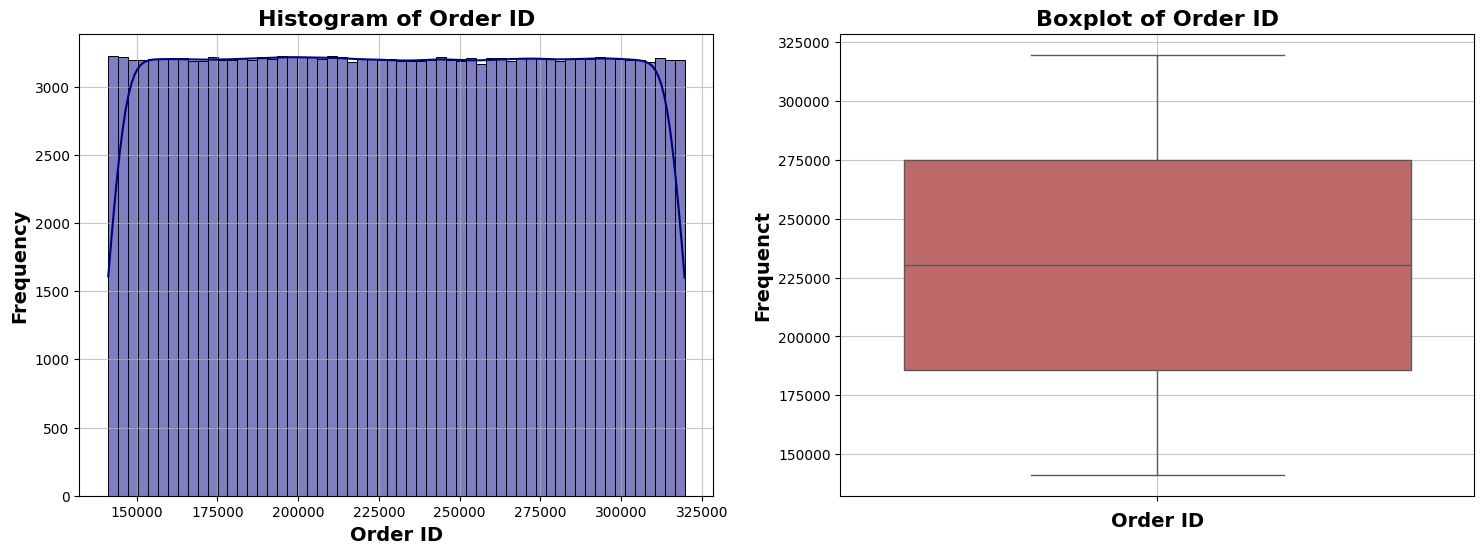

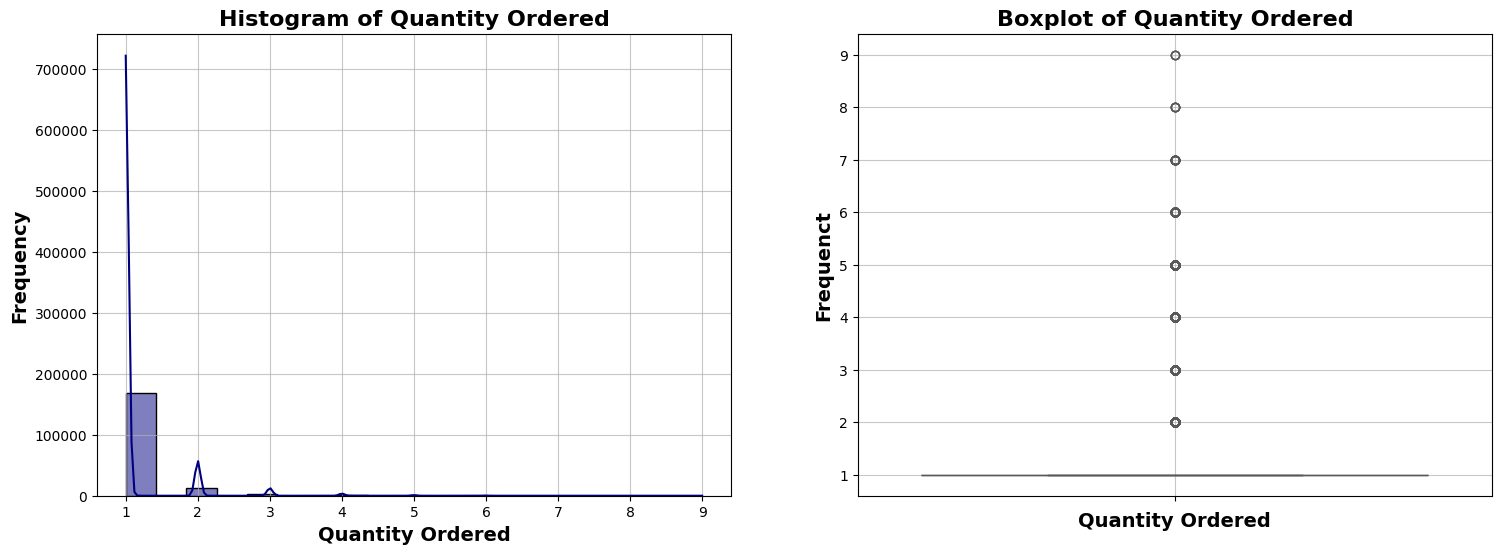

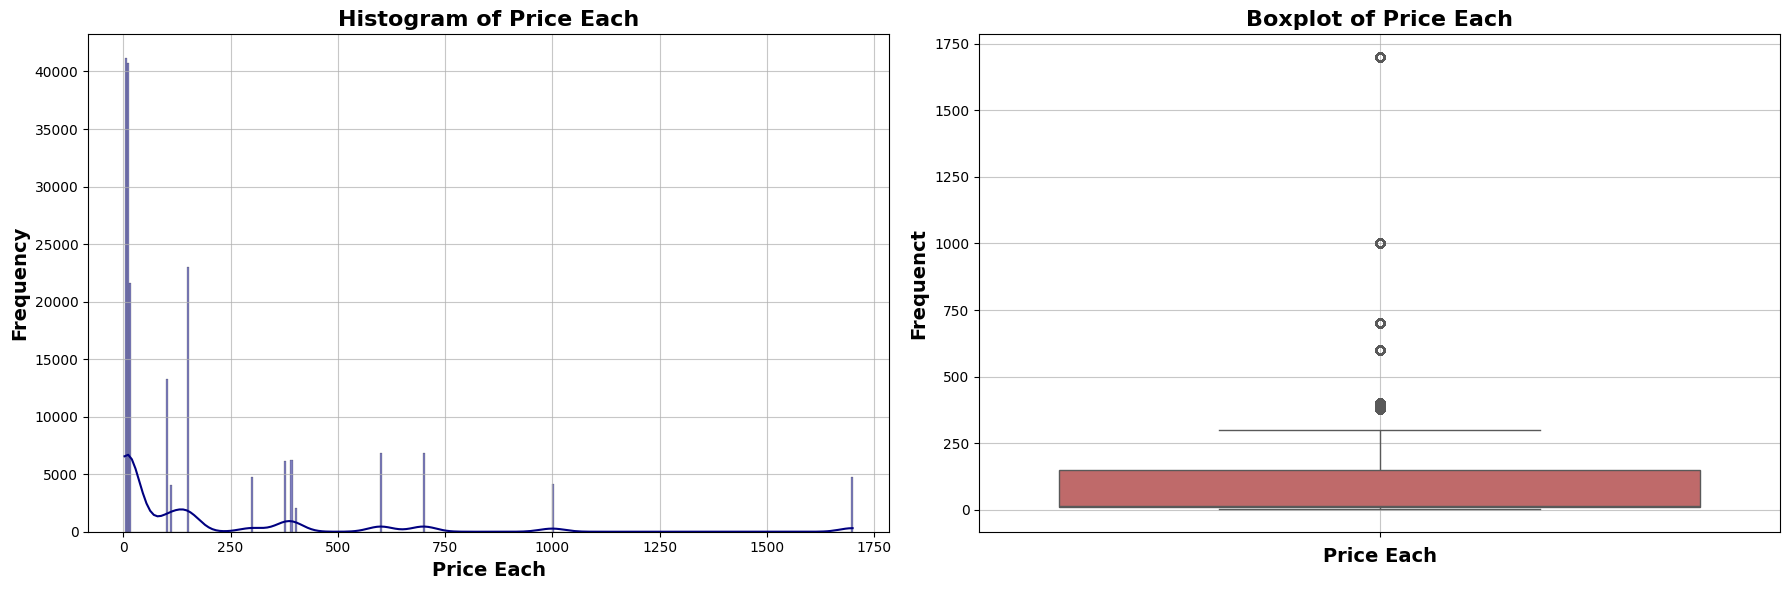

In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
distribution_data(df[numerical_cols])

**Observations :**
1. Outliers are identified in `Quantity Ordered` column with a quantity of above 2
2. Outliers are identified in `Price Each` column with a quantity of above around 300 USD

These outliers will be kept since the values make sense

# **EXPLORATORY DATA ANALYSIS**

Exploratory Data Analysis will be done based on these questions :
1. What was the total revenue, number of orders, and quantity of items sold throughout 2019? What was the average number of items purchased per transaction and the average spending per transaction during 2019?

2. What was the number of orders and GMV over the following time ranges (Daily, Weekly, Monthly)?
**Notes :**GMV is calculated based on total spending by customers, considering all the fee and discounts

3. What are the top 10 products that generated the highest revenue in the last 3 months? Based on this, which products could be bundled together to potentially increase sales?

4. Which are the top 5 cities with the highest number of orders? Which are the top 5 cities with the highest total and average customer spending?

5. During which hours of the day does the highest sales activity (rush hour) occur?


## **Total Revenue, Number of Orders, and Quantity Sold**

In [ ]:
# check order date
print(f'Min Order Date : {df["Order Date"].min()}')
print(f'Max Order Date : {df["Order Date"].max()}')

Min Order Date : 2019-01-01 03:07:00
Max Order Date : 2020-01-01 05:13:00


In [ ]:
# drop order date if it's not 2019
df = df[df['Order Date'].dt.year == 2019]

# recheck
print(f'Min Order Date : {df["Order Date"].min()}')
print(f'Max Order Date : {df["Order Date"].max()}')

Min Order Date : 2019-01-01 03:07:00
Max Order Date : 2019-12-31 23:53:00


In [ ]:
# make a new column "Revenue"
df['Revenue'] = df['Quantity Ordered'] * df['Price Each']

# calculate total revenue
total_revenue = df['Revenue'].sum()

# calculate total orders
total_orders = df['Order ID'].nunique()

# calculate total quantity
total_quantity = df['Quantity Ordered'].sum()

# calculate average number of items per purchase
avg_items = total_quantity / total_orders

# calculate average spending per purchase
avg_spending = total_revenue / total_orders

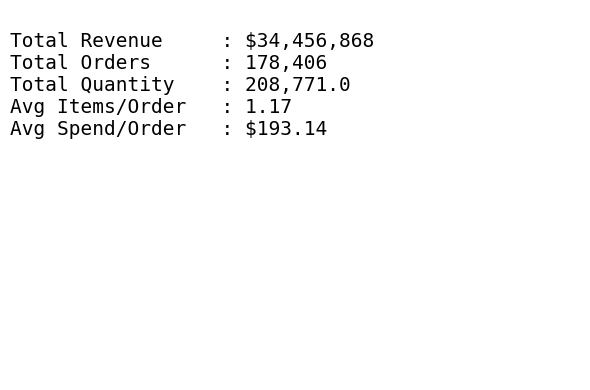

In [ ]:
# Plot a figure
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')  #remove axis

# summary text
summary_text = f'''
Total Revenue     : ${total_revenue:,.0f}
Total Orders      : {total_orders:,}
Total Quantity    : {total_quantity:,}
Avg Items/Order   : {avg_items:.2f}
Avg Spend/Order   : ${avg_spending:.2f}
'''

# add text
ax.text(0, 1, summary_text, fontsize=14, verticalalignment='top', family='monospace')

plt.tight_layout()
plt.show()


**Insights :** Throughout 2019, the total revenue reached 34.45 billion USD, with 178,406 orders and 208,771 items sold. In each transaction, there were 1.17  1 items sold and generated an average spending of 193.14 usd.

## **Number of Orders and GMV over Period**

### **Daily**

In [ ]:
# set "Order Date" as index
df.set_index('Order Date', inplace=True)

# make a new dataframe for resampling to day
df_daily = df.resample('D').agg({
    'Order ID': 'nunique',  # number of orders
    'Revenue': 'sum' # GMV
}).rename(columns={'Order ID': 'Total Orders'})

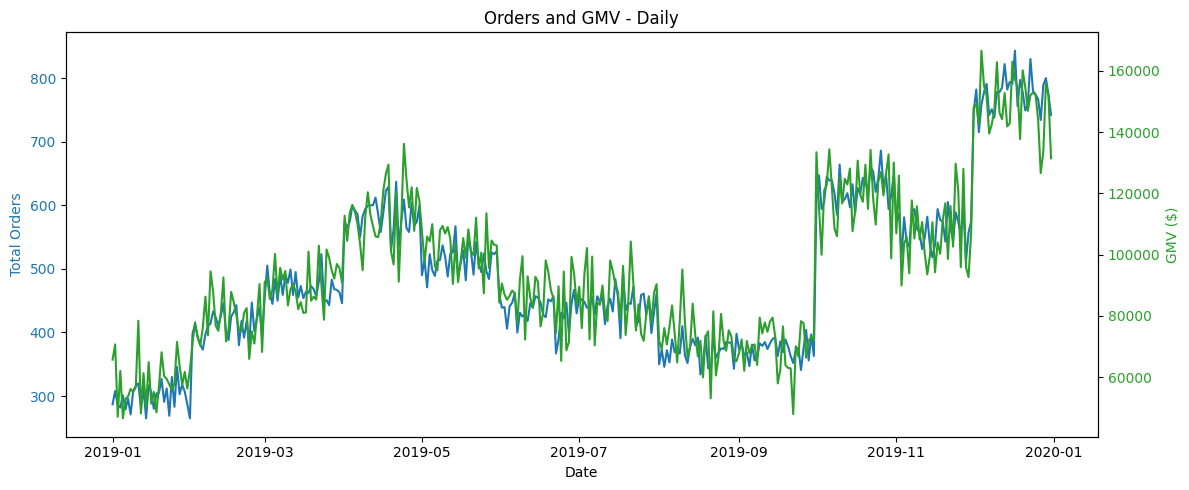

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.set_title(f'Orders and GMV - Daily')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Orders', color='tab:blue')
ax1.plot(df_daily.index, df_daily['Total Orders'], color='tab:blue', label='Total Orders')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('GMV ($)', color='tab:green')
ax2.plot(df_daily.index, df_daily['Revenue'], color='tab:green', label='GMV')
ax2.tick_params(axis='y', labelcolor='tab:green')

fig.tight_layout()
plt.show()

**Insights :**
1. Both number of orders and total GMV fluctuated over 2019
2. Number of orders and total GMV started low in the beginning of year with the first peak at around May 2019, but they declined until around the end of September/October
3. There a drastic increase in number of orders and total GMV in November then tend to stable throughout November before rising drastically in December

### **Weekly**

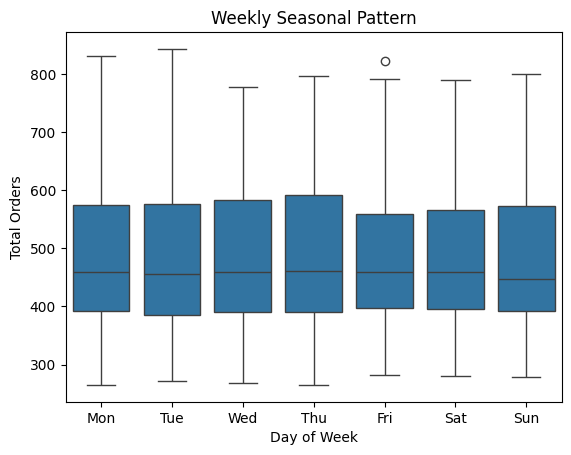

In [ ]:
# Visualization for weekly seasonal pattern
sns.boxplot(x=df_daily.index.dayofweek, y=df_daily['Total Orders'])
plt.xticks(range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Total Orders')
plt.title('Weekly Seasonal Pattern')
plt.show()


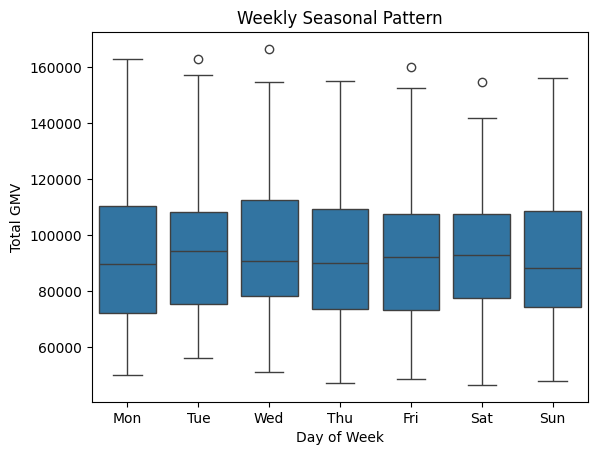

In [ ]:
# Visualization for weekly seasonal pattern
sns.boxplot(x=df_daily.index.dayofweek, y=df_daily['Revenue'])
plt.xticks(range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Total GMV')
plt.title('Weekly Seasonal Pattern')
plt.show()

**Insights :**
1. Number of orders has a similar range over the week (Q1 - Q3 : ~400 - 600 orders) with the number of orders on Sunday has a slightly lower median value compared to other days (Notes : Q1 means the first quartile and Q3 means the third quartile)
2. Although number of orders was relatively the same over the week, median GMV on Tuesday was slightly higher than other days, indicating that customers tend to purchase higher-valued items on this day

### **Monthly**

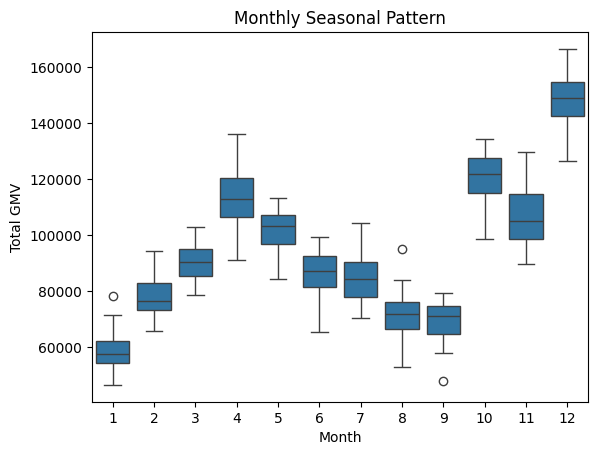

In [ ]:
sns.boxplot(x=df_daily.index.month, y=df_daily['Revenue'])
plt.xlabel('Month')
plt.ylabel('Total GMV')
plt.title('Monthly Seasonal Pattern')
plt.show()

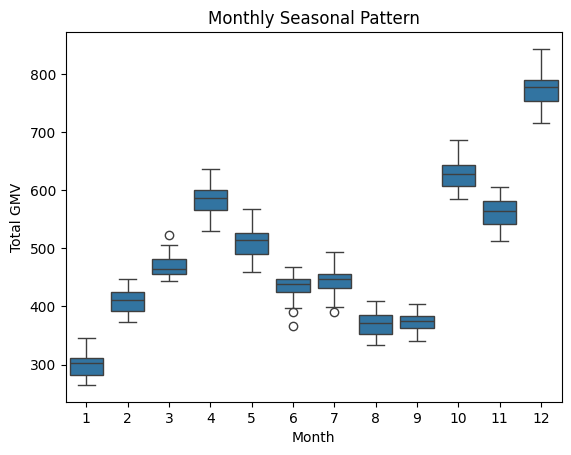

In [ ]:
sns.boxplot(x=df_daily.index.month, y=df_daily['Total Orders'])
plt.xlabel('Month')
plt.ylabel('Total GMV')
plt.title('Monthly Seasonal Pattern')
plt.show()

**Insights :**
1. It can be seen clearly that December becomes the month with the highest GMV and total orders
2. Transactions, in terms of both total orders and GMV, gradually increased from January to April then decreased up to September. At the end of year, transactions increased drastically. It could be happened because of two reasons : (a) Vacation period in the end of year (Christmas and New Year); (b) Black Friday Sale in the end of November/beginning of December

## **Top 10 Most Profitable Products**

In [ ]:
# filter to last 3 months
last_3_months = df.index.max() - pd.DateOffset(months=3)
df_last_3_months = df[df.index >= last_3_months]

# groupby product and calculate total revenue
top_products = df_last_3_months.groupby('Product')['Revenue'].sum().sort_values(ascending=False).head(10)
top_products

,Revenue
Product,
Macbook Pro Laptop,2735300.00
iPhone,1601600.00
ThinkPad Laptop,1371986.28
Google Phone,1082400.00
27in 4K Gaming Monitor,841988.41
Apple Airpods Headphones,787950.00
34in Ultrawide Monitor,786579.30
Flatscreen TV,493800.00
Bose SoundSport Headphones,453054.69


In [ ]:
def visualization_bar(df, title, xlabel, ylabel) :
  plt.figure(figsize=(12,6))
  sns.barplot(x=df.values, y=df.index, palette='viridis')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  # add text
  for index, value in enumerate(df.values) :
    plt.text(
        int(value)/2, # horizontal
        index, # vertical position
        value, # text
      color='white', ha='center', va='center', weight = 'bold', fontsize=12)
  plt.tight_layout()
  plt.show()

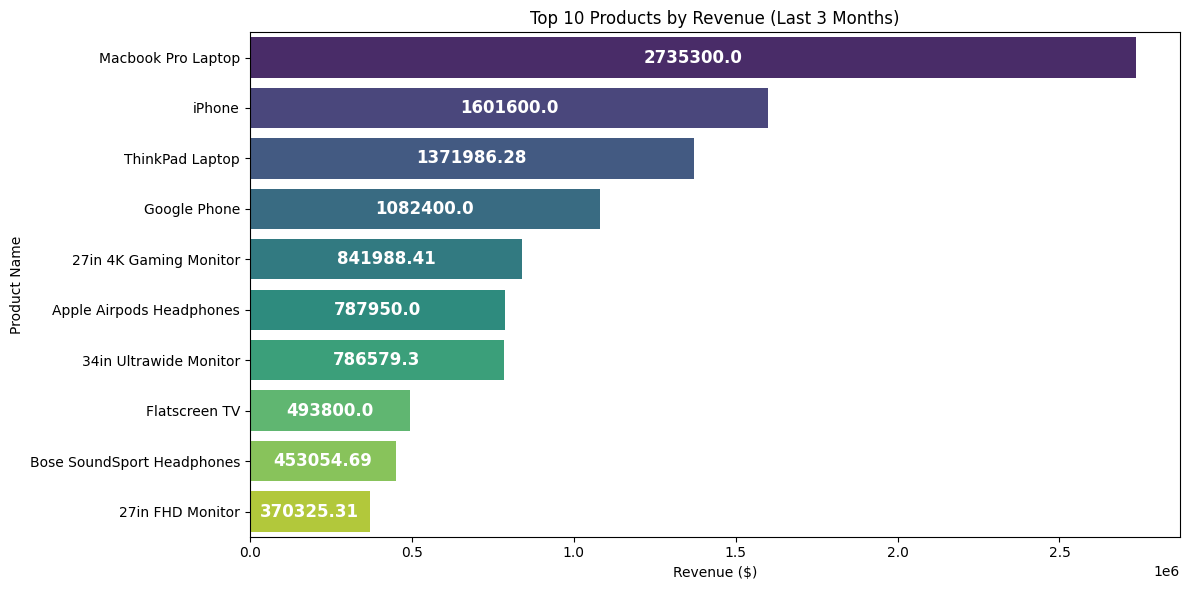

In [ ]:
 visualization_bar(top_products, 'Top 10 Products by Revenue (Last 3 Months)', 'Revenue ($)', 'Product Name')

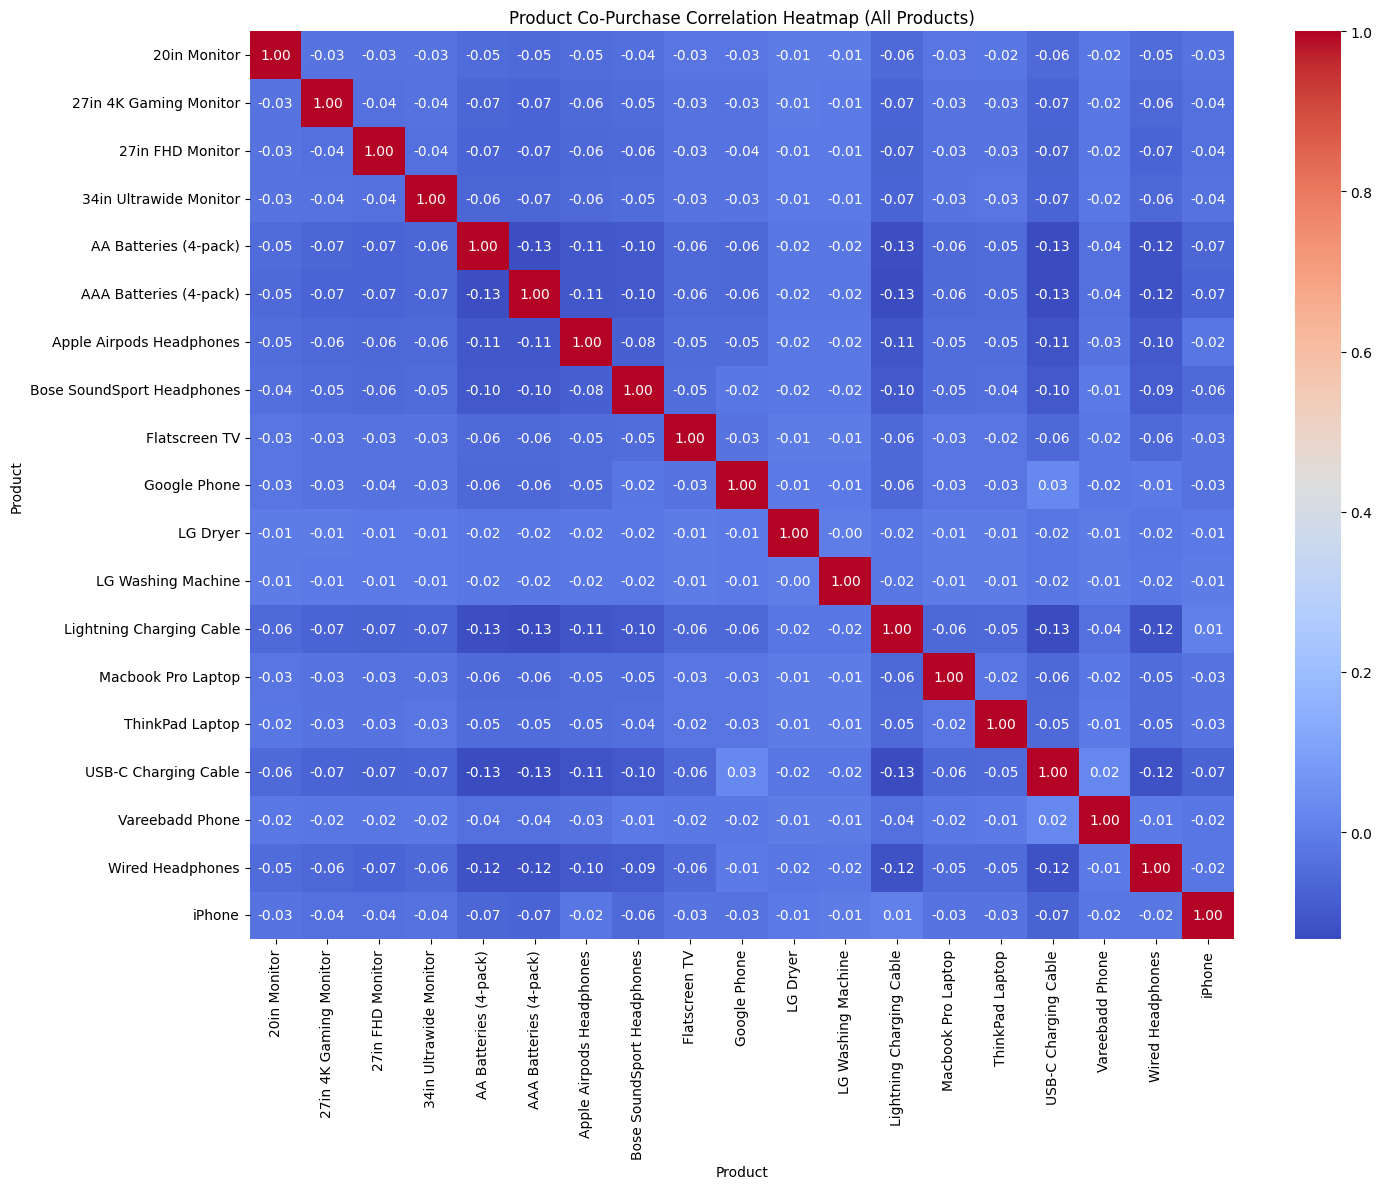

In [ ]:
# product basket
order_product = df_last_3_months[df_last_3_months['Product'].notna()]
basket = (
    order_product.groupby(['Order ID', 'Product'])['Quantity Ordered']
    .sum().unstack().fillna(0)
)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# correlation for products
corr_matrix = basket.corr()

# visualization
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, cmap='coolwarm',annot=True, fmt='.2f')
plt.title('Product Co-Purchase Correlation Heatmap (All Products)')
plt.tight_layout()
plt.show()


**Insights :**
1. Apple products (iPhone and MacBook) dominated the top two ranks among the 10 most profitable products
2. In general, monitor dominated top 10 most profitable products, indicating high demand in 2019
3. All the products have weak correlation with each other. At least only 4-pack batteries, both AA and AAA batteries have a slightly higher correlation (>= 0 .1) with all brands of headphone and all types of charging cable, indicating that batteries can be bundled with with either headphones or charging cable

## **Top 5 Cities**

In [ ]:
# make a function to get city
def get_city(address) :
  return address.split(', ')[1]

df['City'] = df['Purchase Address'].apply(get_city)
df

,Order ID,Product,Quantity Ordered,Price Each,Purchase Address,Revenue,City
Order Date,,,,,,,
2019-01-01 03:07:00,147268.0,Wired Headphones,1.0,11.99,"9 Lake St, New York City, NY 10001",11.99,New York City
2019-01-01 03:40:00,148041.0,USB-C Charging Cable,1.0,11.95,"760 Church St, San Francisco, CA 94016",11.95,San Francisco
2019-01-01 04:56:00,149343.0,Apple Airpods Headphones,1.0,150.00,"735 5th St, New York City, NY 10001",150.00,New York City
2019-01-01 05:53:00,149964.0,AAA Batteries (4-pack),1.0,2.99,"75 Jackson St, Dallas, TX 75001",2.99,Dallas
2019-01-01 06:03:00,149350.0,USB-C Charging Cable,2.0,11.95,"943 2nd St, Atlanta, GA 30301",23.90,Atlanta
...,...,...,...,...,...,...,...
2019-12-31 23:42:00,297481.0,AA Batteries (4-pack),1.0,3.84,"82 Hill St, Dallas, TX 75001",3.84,Dallas
2019-12-31 23:42:00,298406.0,AAA Batteries (4-pack),2.0,2.99,"30 Elm St, San Francisco, CA 94016",5.98,San Francisco
2019-12-31 23:45:00,317048.0,AAA Batteries (4-pack),2.0,2.99,"743 Adams St, San Francisco, CA 94016",5.98,San Francisco


In [ ]:
top_5_cities_orders = df.groupby('City')['Order ID'].nunique().sort_values(ascending=False).head(5)
top_5_cities_orders

,Order ID
City,
San Francisco,42887
Los Angeles,28497
New York City,23840
Boston,19088
Atlanta,14253


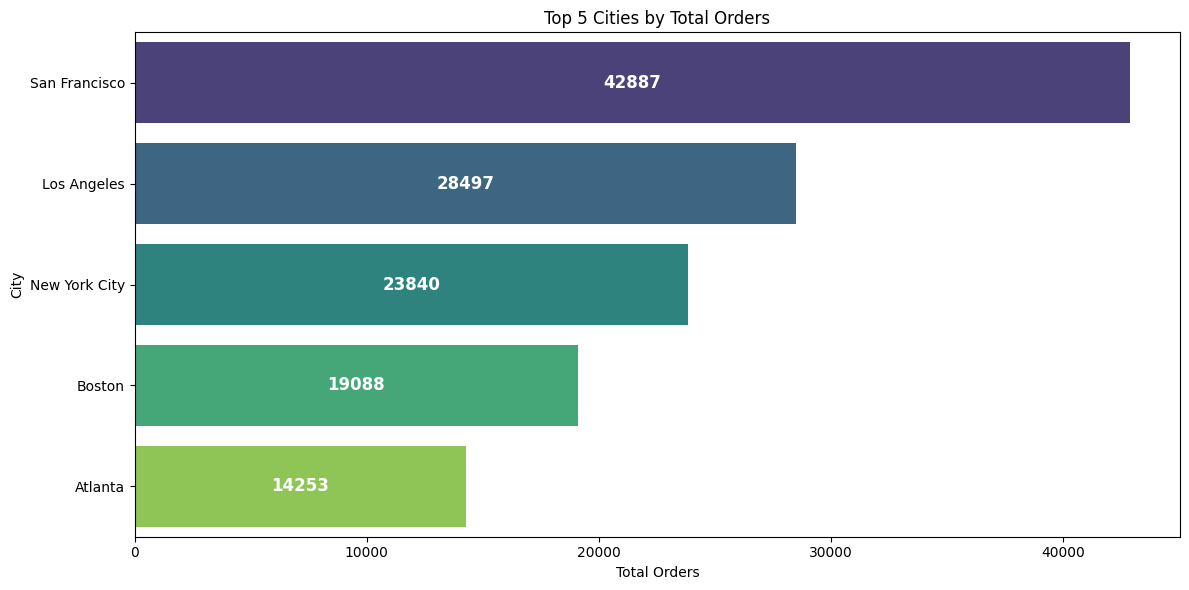

In [ ]:
visualization_bar(top_5_cities_orders, 'Top 5 Cities by Total Orders', 'Total Orders', 'City' )

In [ ]:
top_5_cities_total_spending = df.groupby('City')['Revenue'].sum().sort_values(ascending=False).head(5)
top_5_cities_total_spending

,Revenue
City,
San Francisco,8252258.67
Los Angeles,5447304.29
New York City,4660526.52
Boston,3657300.76
Atlanta,2794199.07


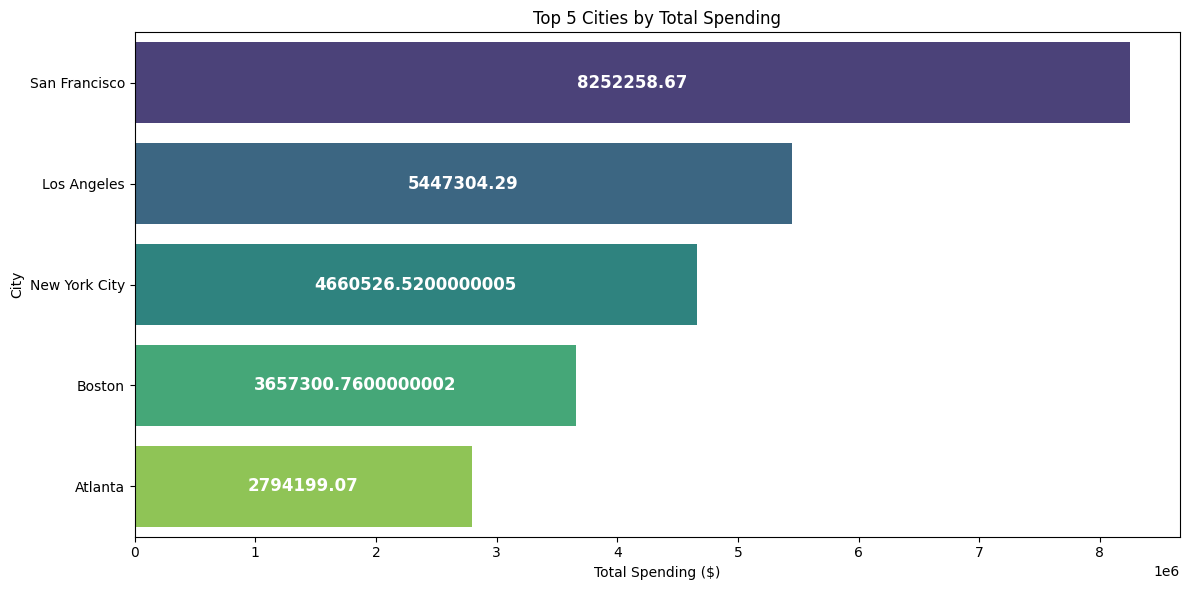

In [ ]:
visualization_bar(top_5_cities_total_spending, 'Top 5 Cities by Total Spending', 'Total Spending ($)', 'City')

In [ ]:
top_5_cities_avg_spending = df.groupby('City')['Revenue'].mean().sort_values(ascending=False).head(5)
top_5_cities_avg_spending

,Revenue
City,
Atlanta,187.996977
New York City,187.644503
Dallas,186.796824
Seattle,186.575315
Portland,186.324331


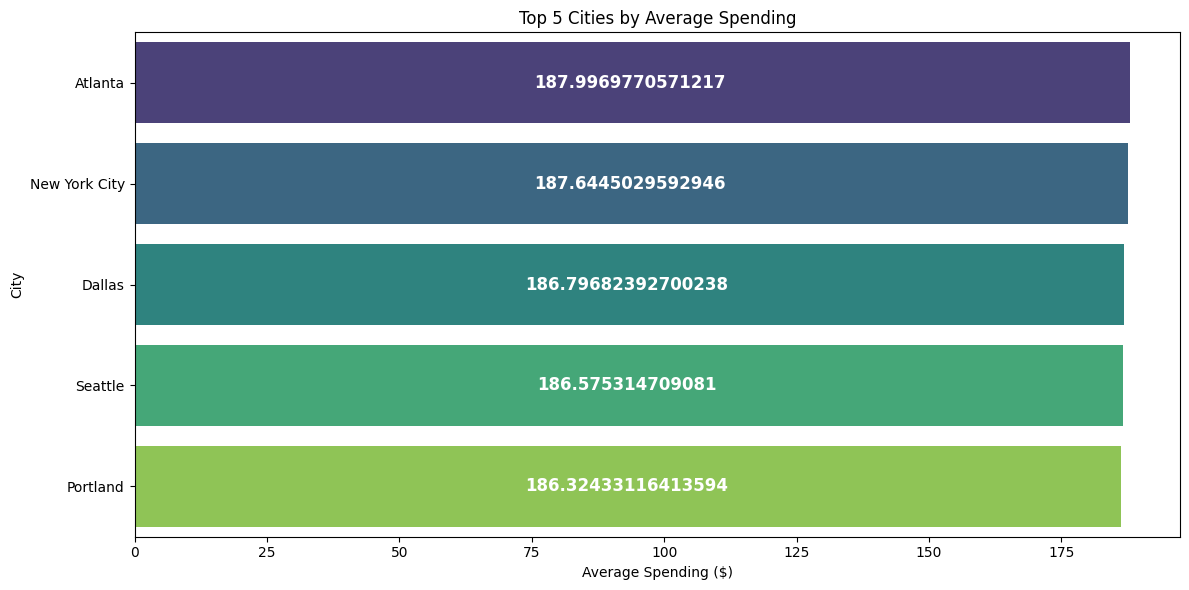

In [ ]:
visualization_bar(top_5_cities_avg_spending, 'Top 5 Cities by Average Spending', 'Average Spending ($)', 'City')

**Insights :**
1. Although San Fransisco, Los Angeles, and Boston consistently ranked among the top 5 cities in terms of number of orders and total spending, these cities were not in the list of top 5 cities with the highest average spending. This indicates that customers living in these cities tend to spend less money in each transaction
2. Despite ranking the bottom in the list of top 5 cities with the most number of orders and the highest total spending, Atlanta ranked first for the highest average spending. This indicates that customers living in Atlanta tend to make fewer purchases, but each transaction is of higher value
3. New York City consistently ranked among the top 3 cities in terms of number of orders, total spending, and average spending. This indicates that New York City is is a highly valuable market hub
4. Dallas, Seattle, and Portland became top 5 cities with the highest average spending, but did not appear in the list of top 5 cities with the highest orders. This indicates that these cities are potential market and need to be paid attention to increase their orders

## **Rush Hour**

In [ ]:
# Make a new column "Hour"
df['Hour'] = df.index.hour

# Calculate total orders
orders_per_hour = df.groupby('Hour')['Order ID'].nunique().reset_index()
orders_per_hour.columns = ['Hour', 'Total Orders']

# make a function for rush hour visualization
def visualization_rush_hour(df,y, title,  ylabel) :
  plt.figure(figsize=(12,6))
  sns.barplot(data=df, x='Hour', y=y, palette='viridis')
  plt.title(title, fontsize=14)
  plt.xlabel('Hour', fontsize=12)
  plt.ylabel(ylabel, fontsize=12)
  plt.xticks(range(0, 24))
  plt.grid(axis='y', linestyle='--', alpha=0.5)
  plt.tight_layout()
  plt.show()

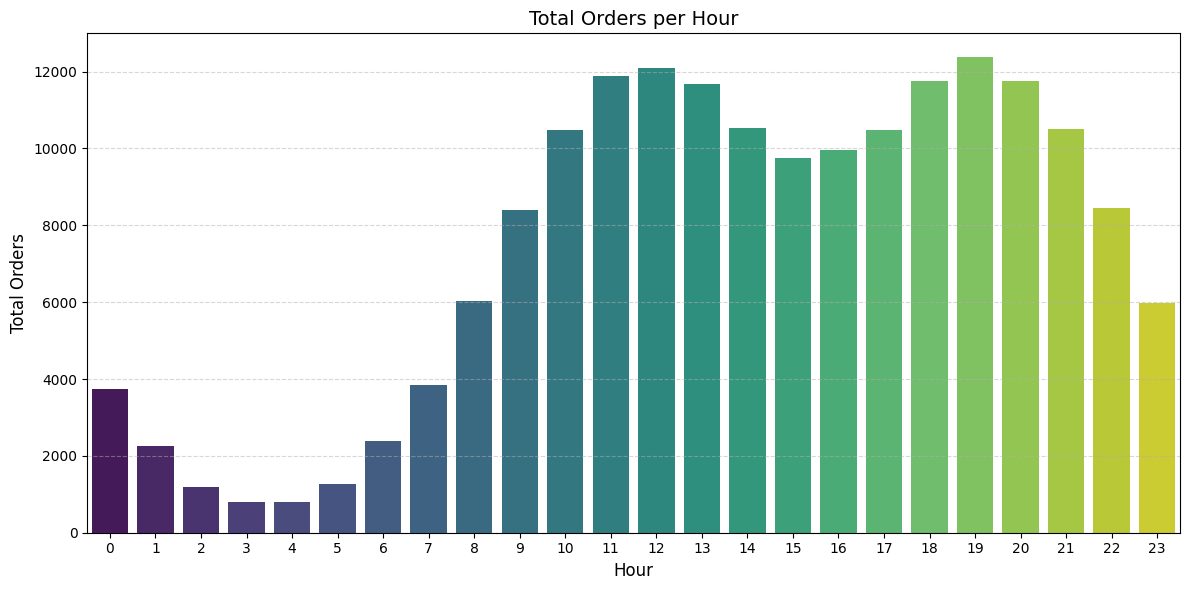

In [ ]:
visualization_rush_hour(orders_per_hour, 'Total Orders', 'Total Orders per Hour', 'Total Orders')

In [ ]:
# Calculate total revenue per hour
revenue_per_hour = df.groupby('Hour')['Revenue'].sum().reset_index()
revenue_per_hour.columns = ['Hour', 'Total Revenue']

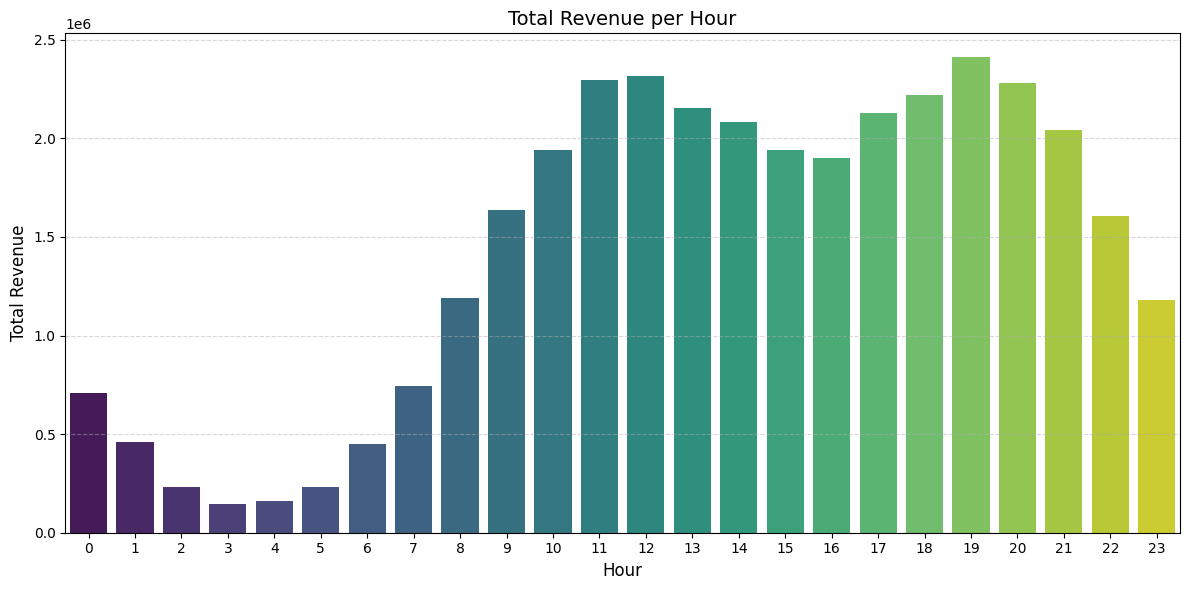

In [ ]:
visualization_rush_hour(revenue_per_hour, 'Total Revenue', 'Total Revenue per Hour', 'Total Revenue')

**Insights :**
1. More orders resulted in higher revenue generated
2. The peak time of transactions on the e-commerce was 7 pm. This is time when people usually at home and rest, so it makes sense to have the highest transaction volume. This indicates that marketing division could schedule promotional campaigns or flash sales around this time to maximize customer engagement and conversion rates
3. Besides 6 - 8 pm, 11 am - 12 pm is also time when people tend to shop on the e-commerce

# **STATIONARITY TEST**

## **Total Transactions**

In [ ]:
df_daily = df_daily.dropna(subset=['Total Orders'])
df_daily['Total Orders'] = pd.to_numeric(df_daily['Total Orders'], errors='coerce')

In [ ]:
# Stationarity test ADF
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_daily['Total Orders'])
pvalue = dftest[1]
print(f'P-value: {pvalue}')

if pvalue > 0.05:
    print('Data non-stationary')
else:
    print('Data stationary')

P-value: 0.7025177855652346
Data non-stationary


## **Total Visitors**

Since there is no customer id in dataset, it's a little bit difficult to forecast total visitors. To deal with it, it is assumed that one visitor is represented by their purchase address

In [ ]:
df_daily_visitors = df.resample('D').agg({
    'Purchase Address': 'nunique',  # number of purchase address
}).rename(columns={'Purchase Address': 'Total Visitors'})
df_daily_visitors.head()

,Total Visitors
Order Date,
2019-01-01,287
2019-01-02,308
2019-01-03,285
2019-01-04,282
2019-01-05,301


In [ ]:
dftest = adfuller(df_daily_visitors['Total Visitors'])
pvalue = dftest[1]
print(f'P-value: {pvalue}')

if pvalue > 0.05:
    print('Data non-stationary')
else:
    print('Data stationary')

P-value: 0.7022862094887943
Data non-stationary


# **PLOT AUTOCORRELATION FUNCTION (ACF) AND PARTIAL AUTOCORRELATION FUNCTION (PACF)**

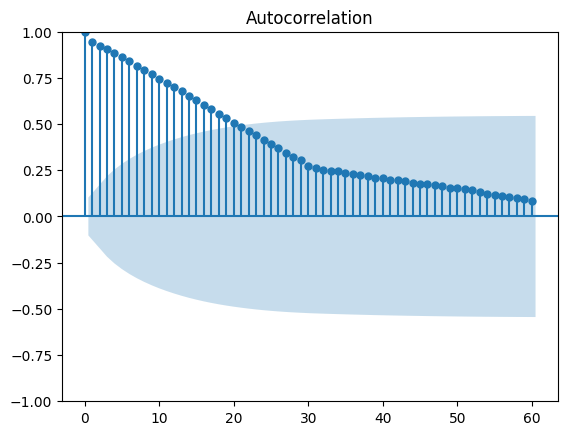

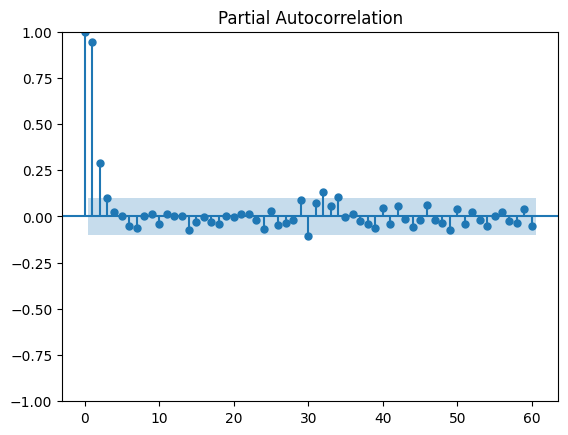

In [ ]:
# make ACF and PACF plots

# Plot ACF
plot_acf(df_daily['Total Orders'], lags=60)
plt.show()

# Plot PACF
plot_pacf(df_daily['Total Orders'], lags=60)
plt.show()

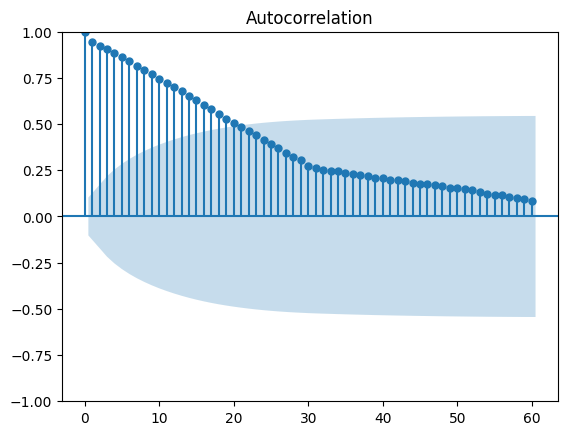

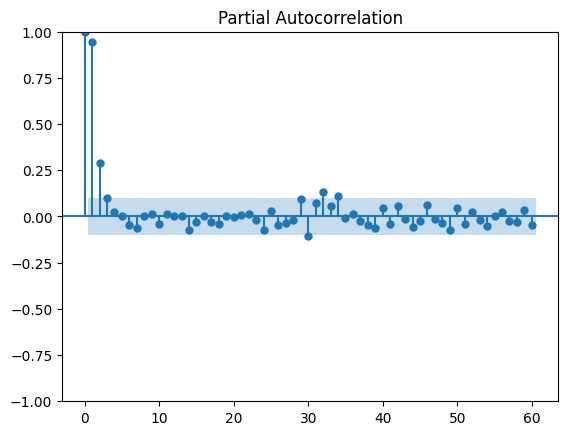

In [ ]:
# Plot ACF
plot_acf(df_daily_visitors['Total Visitors'], lags=60)
plt.show()

# Plot PACF
plot_pacf(df_daily_visitors['Total Visitors'], lags=60)
plt.show()

**Insights :**
1. Plot ACF shows high autocorrelation in the first lags for both total orders and total visitors
2. Plot PACF shows that lag 1 and lag 2 have significant PACF values which indicates that today's total orders are highly influenced by the values from 1-2 days ago for both total orders and total visitors

# **DATA PREPARATION**

## **Advanced Feature Engineering**

In [ ]:
# extract time features
def create_time_features_daily(df_input):
    df_output = df_input.copy()
    df_output['year'] = df_output.index.year
    df_output['month'] = df_output.index.month
    df_output['day'] = df_output.index.day # day of month
    df_output['dayofweek'] = df_output.index.dayofweek
    df_output['dayofyear'] = df_output.index.dayofyear
    df_output['weekofyear'] = df_output.index.isocalendar().week.astype(int)
    df_output['quarter'] = df_output.index.quarter
    df_output['is_weekend'] = (df_output.index.dayofweek >= 5).astype(int)

    # seasonal cyclic
    df_output['dayofweek_sin'] = np.sin(2 * np.pi * df_output['dayofweek']/7)
    df_output['dayofweek_cos'] = np.cos(2 * np.pi * df_output['dayofweek']/7)
    df_output['dayofyear_sin'] = np.sin(2 * np.pi * df_output['dayofyear']/365)
    df_output['dayofyear_cos'] = np.cos(2 * np.pi * df_output['dayofyear']/365)
    df_output['month_sin'] = np.sin(2 * np.pi * df_output['month']/12)
    df_output['month_cos'] = np.cos(2 * np.pi * df_output['month']/12)
    return df_output

df_features = create_time_features_daily(df_daily)

In [ ]:
df_features.head()

,Total Orders,Revenue,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_weekend,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,month_sin,month_cos
Order Date,,,,,,,,,,,,,,,,
2019-01-01,287,65681.94,2019,1,1,1,1,1,1,0,0.781831,0.623490,0.017213,0.999852,0.5,0.866025
2019-01-02,308,70663.20,2019,1,2,2,2,1,1,0,0.974928,-0.222521,0.034422,0.999407,0.5,0.866025
2019-01-03,286,47046.20,2019,1,3,3,3,1,1,0,0.433884,-0.900969,0.051620,0.998667,0.5,0.866025
2019-01-04,282,62000.22,2019,1,4,4,4,1,1,0,-0.433884,-0.900969,0.068802,0.997630,0.5,0.866025
2019-01-05,301,46524.63,2019,1,5,5,5,1,1,1,-0.974928,-0.222521,0.085965,0.996298,0.5,0.866025


In [ ]:
df_visitors = create_time_features_daily(df_daily_visitors)
df_visitors.head()

,Total Visitors,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_weekend,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,month_sin,month_cos
Order Date,,,,,,,,,,,,,,,
2019-01-01,287,2019,1,1,1,1,1,1,0,0.781831,0.623490,0.017213,0.999852,0.5,0.866025
2019-01-02,308,2019,1,2,2,2,1,1,0,0.974928,-0.222521,0.034422,0.999407,0.5,0.866025
2019-01-03,285,2019,1,3,3,3,1,1,0,0.433884,-0.900969,0.051620,0.998667,0.5,0.866025
2019-01-04,282,2019,1,4,4,4,1,1,0,-0.433884,-0.900969,0.068802,0.997630,0.5,0.866025
2019-01-05,301,2019,1,5,5,5,1,1,1,-0.974928,-0.222521,0.085965,0.996298,0.5,0.866025


In [ ]:
# lag feature and rolling window
def create_lag_rolling_features_power(df_input, target_col):
    df_temp = df_input.copy()

    # Lag features
    df_temp[f'{target_col}_lag_1'] = df_temp[target_col].shift(1) # yesterday
    df_temp[f'{target_col}_lag_7'] = df_temp[target_col].shift(7) #weekly seasonal
    df_temp[f'{target_col}_lag_365'] = df_temp[target_col].shift(365) # yearly seasonal

    # Rolling window features
    df_temp[f'{target_col}_rolling_mean_7'] = df_temp[target_col].rolling(window=7, min_periods=1).mean()
    df_temp[f'{target_col}_rolling_std_7'] = df_temp[target_col].rolling(window=7, min_periods=1).std()
    df_temp[f'{target_col}_rolling_mean_30'] = df_temp[target_col].rolling(window=30, min_periods=1).mean()

    return df_temp

df_features = create_lag_rolling_features_power(df_features, 'Total Orders')
df_visitors = create_lag_rolling_features_power(df_visitors, 'Total Visitors')

In [ ]:
# Missing values handling
# fill in NaN after shift/rolling
for col in df_features.columns:
    if df_features[col].isnull().any():
        df_features[col].fillna(df_features[col].mean(), inplace=True)

In [ ]:
# Missing values handling
# fill in NaN after shift/rolling
for col in df_visitors.columns:
    if df_visitors[col].isnull().any():
        df_visitors[col].fillna(df_visitors[col].mean(), inplace=True)

In [ ]:
df_visitors.shape

(365, 21)

In [ ]:
df_features.shape

(365, 22)

In [ ]:
df_features

,Total Orders,Revenue,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_weekend,...,dayofyear_sin,dayofyear_cos,month_sin,month_cos,Total Orders_lag_1,Total Orders_lag_7,Total Orders_lag_365,Total Orders_rolling_mean_7,Total Orders_rolling_std_7,Total Orders_rolling_mean_30
Order Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,287,65681.94,2019,1,1,1,1,1,1,0,...,1.721336e-02,0.999852,5.000000e-01,0.866025,488.087912,483.312849,NaN,287.000000,26.897259,287.000000
2019-01-02,308,70663.20,2019,1,2,2,2,1,1,0,...,3.442161e-02,0.999407,5.000000e-01,0.866025,287.000000,483.312849,NaN,297.500000,14.849242,297.500000
2019-01-03,286,47046.20,2019,1,3,3,3,1,1,0,...,5.161967e-02,0.998667,5.000000e-01,0.866025,308.000000,483.312849,NaN,293.666667,12.423097,293.666667
2019-01-04,282,62000.22,2019,1,4,4,4,1,1,0,...,6.880243e-02,0.997630,5.000000e-01,0.866025,286.000000,483.312849,NaN,290.750000,11.701140,290.750000
2019-01-05,301,46524.63,2019,1,5,5,5,1,1,1,...,8.596480e-02,0.996298,5.000000e-01,0.866025,282.000000,483.312849,NaN,292.800000,11.122050,292.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,734,126604.07,2019,12,27,4,361,52,4,0,...,-6.880243e-02,0.997630,-2.449294e-16,1.000000,767.000000,778.000000,NaN,770.285714,30.565309,751.433333
2019-12-28,789,133601.53,2019,12,28,5,362,52,4,1,...,-5.161967e-02,0.998667,-2.449294e-16,1.000000,734.000000,749.000000,NaN,776.000000,29.647934,760.666667
2019-12-29,800,156009.67,2019,12,29,6,363,52,4,1,...,-3.442161e-02,0.999407,-2.449294e-16,1.000000,789.000000,758.000000,NaN,782.000000,29.647934,768.766667


In [ ]:
df_visitors

,Total Visitors,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_weekend,dayofweek_sin,...,dayofyear_sin,dayofyear_cos,month_sin,month_cos,Total Visitors_lag_1,Total Visitors_lag_7,Total Visitors_lag_365,Total Visitors_rolling_mean_7,Total Visitors_rolling_std_7,Total Visitors_rolling_mean_30
Order Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,287,2019,1,1,1,1,1,1,0,0.781831,...,1.721336e-02,0.999852,5.000000e-01,0.866025,487.725275,482.958101,NaN,287.000000,26.901816,287.000000
2019-01-02,308,2019,1,2,2,2,1,1,0,0.974928,...,3.442161e-02,0.999407,5.000000e-01,0.866025,287.000000,482.958101,NaN,297.500000,14.849242,297.500000
2019-01-03,285,2019,1,3,3,3,1,1,0,0.433884,...,5.161967e-02,0.998667,5.000000e-01,0.866025,308.000000,482.958101,NaN,293.333333,12.741010,293.333333
2019-01-04,282,2019,1,4,4,4,1,1,0,-0.433884,...,6.880243e-02,0.997630,5.000000e-01,0.866025,285.000000,482.958101,NaN,290.500000,11.846237,290.500000
2019-01-05,301,2019,1,5,5,5,1,1,1,-0.974928,...,8.596480e-02,0.996298,5.000000e-01,0.866025,282.000000,482.958101,NaN,292.600000,11.282730,292.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,734,2019,12,27,4,361,52,4,0,-0.433884,...,-6.880243e-02,0.997630,-2.449294e-16,1.000000,766.000000,777.000000,NaN,769.285714,30.098252,750.533333
2019-12-28,787,2019,12,28,5,362,52,4,1,-0.974928,...,-5.161967e-02,0.998667,-2.449294e-16,1.000000,734.000000,749.000000,NaN,774.714286,29.244454,759.733333
2019-12-29,800,2019,12,29,6,363,52,4,1,-0.781831,...,-3.442161e-02,0.999407,-2.449294e-16,1.000000,787.000000,755.000000,NaN,781.142857,29.134336,767.866667


## **Split Data**

In [ ]:
def split_dataset(df, target_col, exog_cols_ts) :
  train_size = int(len(df) * 0.6)
  val_size = int(len(df) * 0.2)
  test_size = len(df) - train_size - val_size

  split_date_val = df.index[train_size - 1]
  split_date_test = df.index[train_size + val_size - 1]

  y_train_ts = df[target_col].iloc[:train_size]
  y_val_ts = df[target_col].iloc[train_size:train_size + val_size]
  y_test_ts = df[target_col].iloc[train_size + val_size:]

  # exog_cols_ts : external features
  # Filter exog_cols_ts to include only columns present in df_features
  exog_cols_ts_filtered = [col for col in exog_cols_ts if col in df.columns]


  exog_train_ts = df[exog_cols_ts_filtered].iloc[:train_size]
  exog_val_ts = df[exog_cols_ts_filtered].iloc[train_size:train_size + val_size]
  exog_test_ts = df[exog_cols_ts_filtered].iloc[train_size + val_size:]

  return exog_train_ts, exog_val_ts, exog_test_ts, y_train_ts, y_val_ts, y_test_ts

In [ ]:
exog_cols_features = [
    'Revenue','year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'is_weekend',
    'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos', 'month_sin', 'month_cos']
exog_train_orders, exog_val_orders, exog_test_orders, y_train_orders, y_val_orders, y_test_orders = split_dataset(df_features,'Total Orders', exog_cols_features)

In [ ]:
exog_cols_visitors = [
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'is_weekend',
    'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos', 'month_sin', 'month_cos']
exog_train_visitors, exog_val_visitors, exog_test_visitors, y_train_visitors, y_val_visitors, y_test_visitors = split_dataset(df_visitors,'Total Visitors', exog_cols_visitors)

In [ ]:
print(f"Training data size TS: {len(y_train_orders)} days")
print(f"Validation data size TS: {len(y_val_orders)} days")
print(f"Testing data size TS: {len(y_test_orders)} days")

Training data size TS: 219 days
Validation data size TS: 73 days
Testing data size TS: 73 days


# **MODELLING**

In [ ]:
# Function for model evaluation
def evaluate_model(y_true, y_pred, model_name):
    # make sure that the prediction is not negative
    y_pred = np.maximum(0, y_pred)

    # evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # avoid divide up by 0
    y_true_cleaned = y_true.copy()
    y_true_cleaned[y_true_cleaned == 0] = 1e-9 # change 0 with the smaller number

    mape = np.mean(np.abs((y_true - y_pred) / y_true_cleaned)) * 100
    print(f"--- {model_name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return rmse, mae, mape

# function for visualization
def plot_predictions(y_train, y_val, y_test, y_pred_val, y_pred_test, model_name):
    plt.figure(figsize=(15, 6))
    plt.plot(y_train.index, y_train, label='Training Data', color='blue', alpha=0.7)

    if y_val is not None:
      plt.plot(y_val.index, y_val, label='Validation Data (Actual)', color='black', linewidth=2)
      if y_pred_val is not None:
        y_pred_val_series = pd.Series(y_pred_val, index=y_val.index)
        plt.plot(y_val.index, y_pred_val_series, label=f'Prediction {model_name} (Validation)', linestyle='--', color='red')


    if y_test is not None:
      plt.plot(y_test.index, y_test, label='Testing Data (Actual)', color='green', linewidth=2)
      if y_pred_test is not None:
        y_pred_test_series = pd.Series(y_pred_test, index=y_test.index)
        plt.plot(y_test.index, y_pred_test_series, label=f'Prediction {model_name} (Testing)', linestyle='--', color='orange')


    plt.title(f'Prediction {model_name} vs. Actual', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Total Orders/Visitors', fontsize=12)

    plt.axvline(x=y_train.index.max(), color='grey', linestyle=':', label='End of Training Data')

    if y_val is not None and len(y_val) > 0:
      plt.axvline(x=y_val.index.max(), color='gray', linestyle='--', label='End of Validation Data')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## **Exponential Smoothing (Holt-Winters)**

--- Holt-Winters (Validation) ---
RMSE: 127.3709
MAE: 74.8900
MAPE: 13.21%


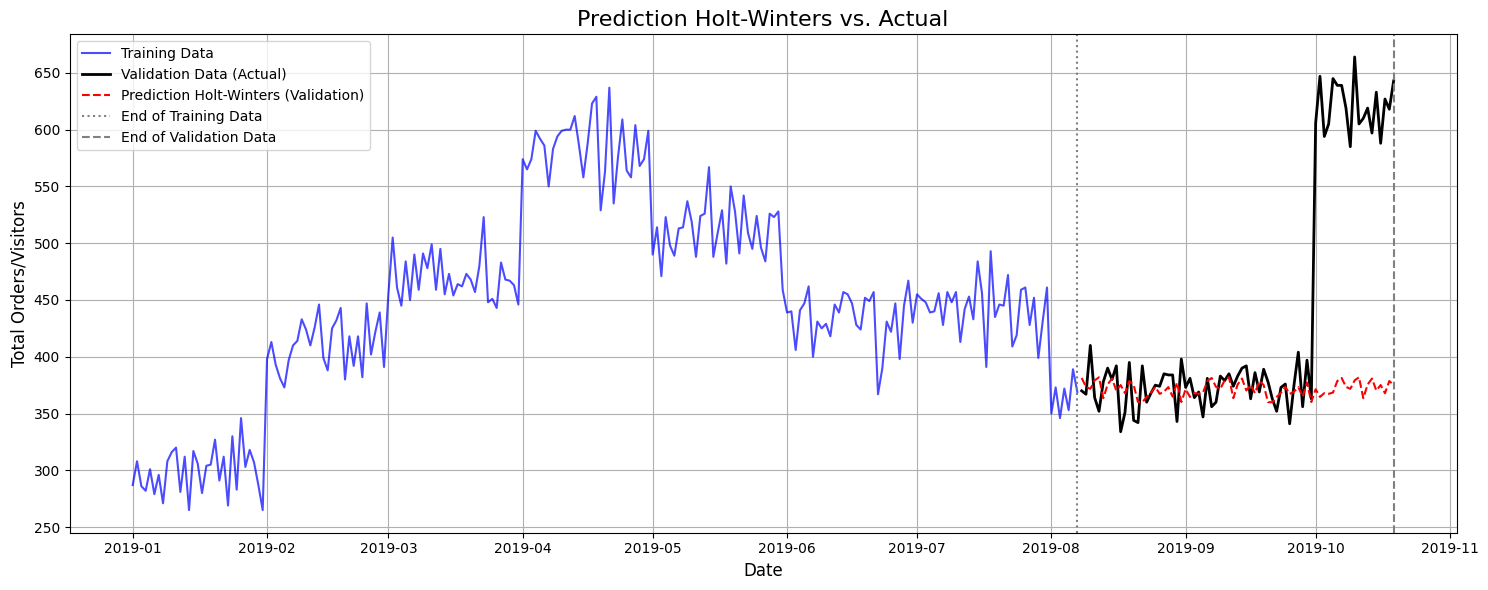

In [ ]:
# modelling for number of transactions
hw_model = ExponentialSmoothing(y_train_orders, seasonal='multiplicative', seasonal_periods=30).fit() # latih model
y_pred_hw_val = hw_model.forecast(len(y_val_orders)) # prediction

rmse_hw_val, mae_hw_val, mape_hw_val = evaluate_model(y_val_orders, y_pred_hw_val, "Holt-Winters (Validation)")
plot_predictions(y_train_orders, y_val_orders, None, y_pred_hw_val, None, "Holt-Winters")

--- Holt-Winters (Validation) ---
RMSE: 127.1781
MAE: 74.7521
MAPE: 13.19%


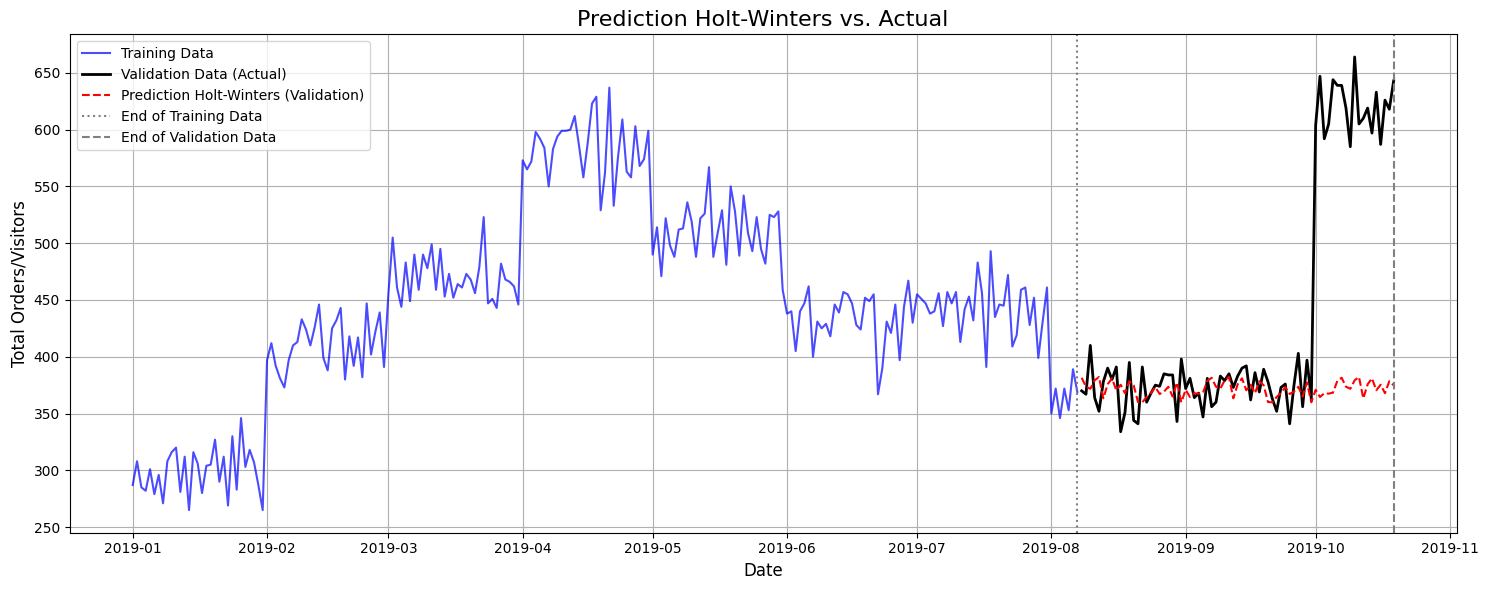

In [ ]:
# modelling for number of visitors
hw_model_visitors = ExponentialSmoothing(y_train_visitors, seasonal='multiplicative', seasonal_periods=30).fit() # latih model
y_pred_hw_val_visitors  = hw_model_visitors .forecast(len(y_val_visitors)) # prediction

rmse_hw_val_visitors , mae_hw_val_visitors , mape_hw_val_visitors  = evaluate_model(y_val_visitors, y_pred_hw_val_visitors , "Holt-Winters (Validation)")
plot_predictions(y_train_visitors , y_val_visitors , None, y_pred_hw_val_visitors , None, "Holt-Winters")

## **SARIMA**

--- SARIMA (0,0,1)(1,1,1,30) (Validation) ---
RMSE: 50.0372
MAE: 36.8565
MAPE: 7.46%


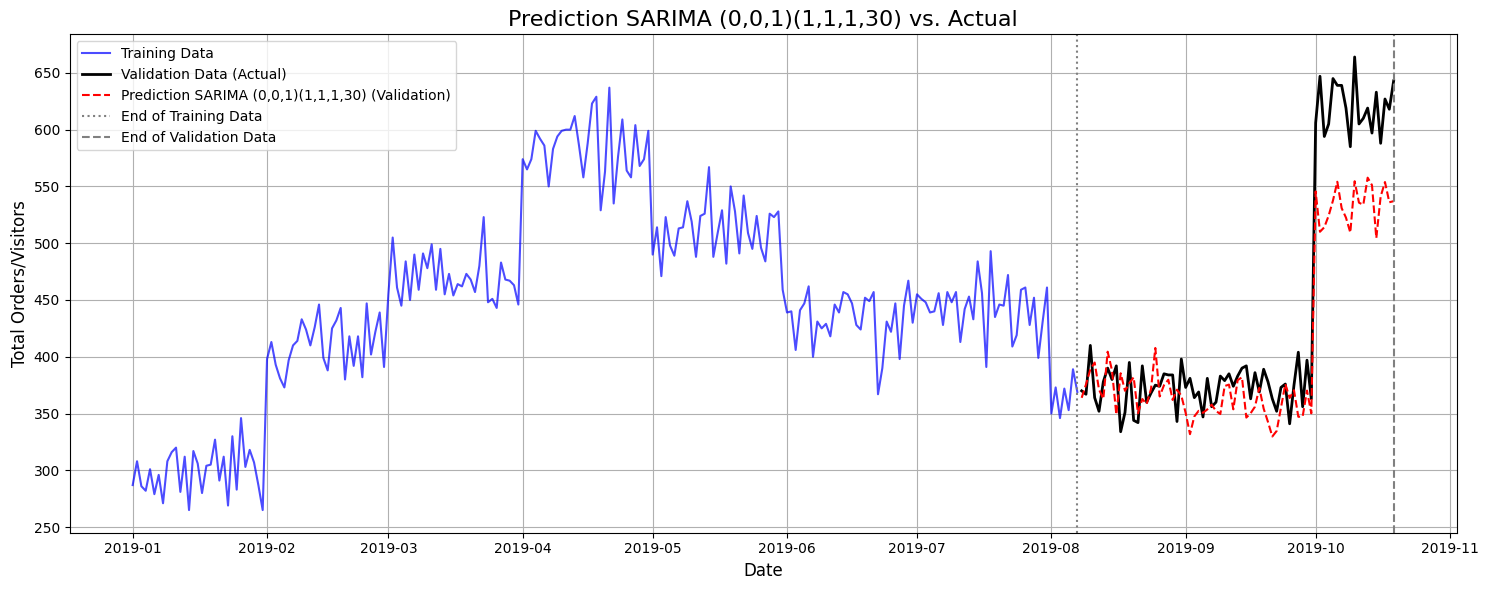

In [ ]:
# MODELLING for number of transactions
sarimax_model = ARIMA(y_train_orders,
                      exog=exog_train_orders,
                      order=(0, 0, 1),
                      seasonal_order=(1, 1, 1, 30)).fit()

y_pred_sarimax_val = sarimax_model.forecast(steps=len(y_val_orders), exog=exog_val_orders)

rmse_sarimax_val, mae_sarimax_val, mape_sarimax_val = evaluate_model(y_val_orders, y_pred_sarimax_val, "SARIMA (0,0,1)(1,1,1,30) (Validation)")

plot_predictions(y_train_orders, y_val_orders, None, y_pred_sarimax_val, None, "SARIMA (0,0,1)(1,1,1,30)")

--- SARIMA (0,0,1)(1,1,1,30) (Validation) ---
RMSE: 58.7712
MAE: 41.4357
MAPE: 8.15%


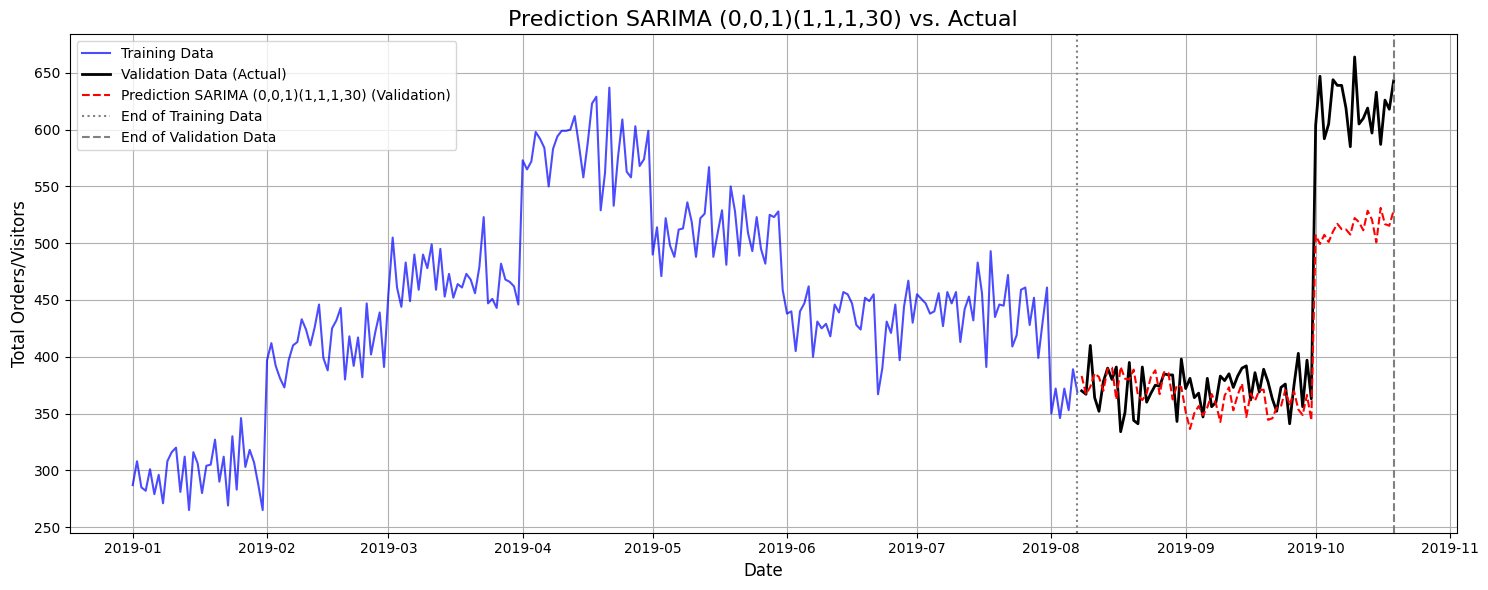

In [ ]:
# MODELLING for number of visitors
sarimax_model_visitors = ARIMA(y_train_visitors,
                      exog=exog_train_visitors,
                      order=(0, 0, 1),
                      seasonal_order=(1, 1, 1, 30)).fit()

y_pred_sarimax_val_visitors = sarimax_model_visitors.forecast(steps=len(y_val_visitors), exog=exog_val_visitors)

rmse_sarimax_val_visitors, mae_sarimax_val_visitors, mape_sarimax_val_visitors = evaluate_model(y_val_visitors, y_pred_sarimax_val_visitors, "SARIMA (0,0,1)(1,1,1,30) (Validation)")

plot_predictions(y_train_visitors, y_val_visitors, None, y_pred_sarimax_val_visitors, None, "SARIMA (0,0,1)(1,1,1,30)")

## **Facebook Prophet**

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_ipig8lg/6bo9fxsm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_ipig8lg/yo9nrmr9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72500', 'data', 'file=/tmp/tmp_ipig8lg/6bo9fxsm.json', 'init=/tmp/tmp_ipig8lg/yo9nrmr9.json', 'output', 'file=/tmp/tmp_ipig8lg/prophet_modelss5mv0ta/prophet_model-20250730055001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:50:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:50:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Prophet (Validation) ---
RMSE: 30.7135
MAE: 23.4523
MAPE: 5.20%


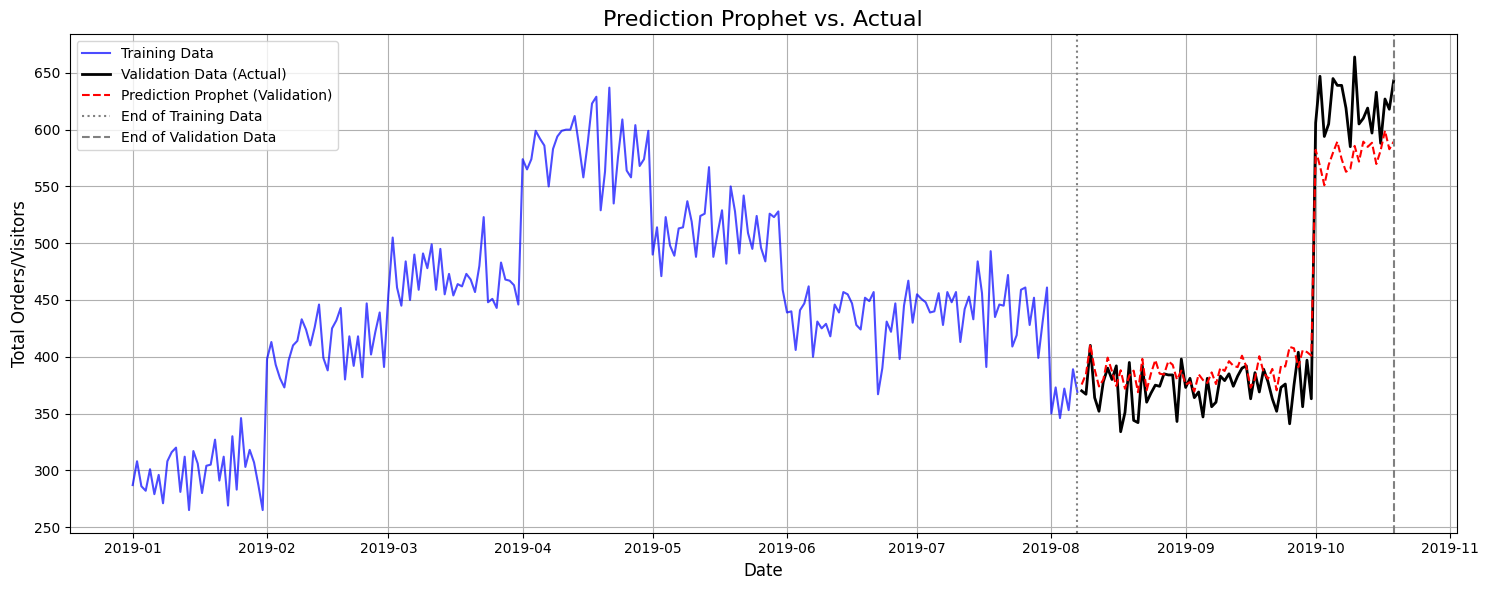

In [ ]:
# modelling for number of transactions
prophet_df_train = y_train_orders.reset_index().rename(columns={'Order Date': 'ds', 'Total Orders': 'y'})
prophet_df_val = y_val_orders.reset_index().rename(columns={'Order Date': 'ds', 'Total Orders': 'y'})

exog_cols = [col for col in exog_train_orders.columns if col != exog_train_orders.index.name]

m = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=True,
            changepoint_prior_scale=0.05)


for col in exog_cols:
    m.add_regressor(col)
prophet_train_with_exog = pd.merge(prophet_df_train, exog_train_orders.reset_index().rename(columns={'Order Date':'ds'}), on='ds', how='left')

m.fit(prophet_train_with_exog)

future_val = m.make_future_dataframe(periods=len(y_val_orders), freq='D', include_history=False)

future_val = pd.merge(future_val, exog_val_orders.reset_index().rename(columns={'Order Date': 'ds'}), on='ds', how='left')

forecast_val = m.predict(future_val)

y_pred_prophet_val = forecast_val['yhat'].values

y_pred_prophet_val = np.maximum(0, y_pred_prophet_val)

y_pred_prophet_val_series = pd.Series(y_pred_prophet_val, index=y_val_orders.index)

rmse_prophet_val, mae_prophet_val, mape_prophet_val = evaluate_model(y_val_orders, y_pred_prophet_val, "Prophet (Validation)")

plot_predictions(y_train_orders, y_val_orders, None, y_pred_prophet_val_series, None, "Prophet")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_ipig8lg/1u6cmu7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_ipig8lg/fwfn8nap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76990', 'data', 'file=/tmp/tmp_ipig8lg/1u6cmu7r.json', 'init=/tmp/tmp_ipig8lg/fwfn8nap.json', 'output', 'file=/tmp/tmp_ipig8lg/prophet_model1ye1j519/prophet_model-20250730055001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:50:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:50:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Prophet (Validation) ---
RMSE: 30.0292
MAE: 23.4000
MAPE: 5.37%


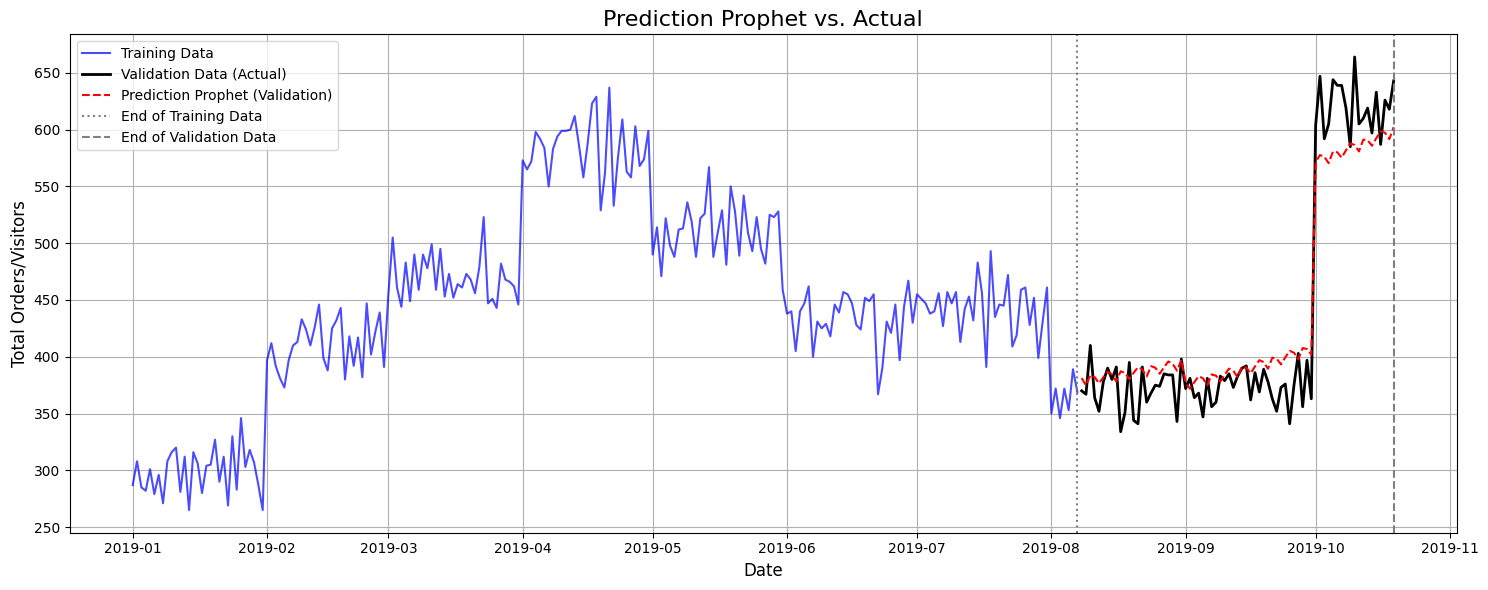

In [ ]:
# modelling for number of transactions
prophet_df_train_visitors = y_train_visitors.reset_index().rename(columns={'Order Date': 'ds', 'Total Visitors': 'y'})
prophet_df_val_visitors = y_val_visitors.reset_index().rename(columns={'Order Date': 'ds', 'Total Visitors': 'y'})

exog_cols_visitors = [col for col in exog_train_visitors.columns if col != exog_train_visitors.index.name]

m_visitors = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=True,
            changepoint_prior_scale=0.05)


for col in exog_cols_visitors:
    m_visitors.add_regressor(col)
prophet_train_with_exog_visitors = pd.merge(prophet_df_train_visitors, exog_train_visitors.reset_index().rename(columns={'Order Date':'ds'}), on='ds', how='left')

m_visitors.fit(prophet_train_with_exog_visitors)

future_val_visitors = m_visitors.make_future_dataframe(periods=len(y_val_visitors), freq='D', include_history=False)

future_val_visitors = pd.merge(future_val_visitors, exog_val_visitors.reset_index().rename(columns={'Order Date': 'ds'}), on='ds', how='left')

forecast_val_visitors = m_visitors.predict(future_val_visitors)

y_pred_prophet_val_visitors = forecast_val_visitors['yhat'].values

y_pred_prophet_val_visitors = np.maximum(0, y_pred_prophet_val_visitors)

y_pred_prophet_val_series_visitors = pd.Series(y_pred_prophet_val_visitors, index=y_val_visitors.index)

rmse_prophet_val_visitors, mae_prophet_val_visitors, mape_prophet_val_visitors = evaluate_model(y_val_visitors, y_pred_prophet_val_visitors, "Prophet (Validation)")

plot_predictions(y_train_visitors, y_val_visitors, None, y_pred_prophet_val_series_visitors, None, "Prophet")

## **Model Comparisons**

If we compare MAPE, Facebook Prophet is the best model for both number of visitors and number of transactions with the MAPE at around 5%

# **RE-TRAIN ON TESTING DATASET**

## **Number of Visitors**

In [ ]:
# merge training + validation for number visitors
y_trainval_visitors = pd.concat([y_train_visitors, y_val_visitors])
exog_trainval_visitors = pd.concat([exog_train_visitors, exog_val_visitors])

#prepare dataset for Prophet
prophet_df_trainval_visitors = y_trainval_visitors.reset_index().rename(columns={'Order Date': 'ds', 'Total Visitors': 'y'})
prophet_trainval_with_exog_visitors = pd.merge(
    prophet_df_trainval_visitors,
    exog_trainval_visitors.reset_index().rename(columns={'Order Date':'ds'}),
    on='ds',
    how='left'
)


In [ ]:
m_final_visitors = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.05
)

# Tambahkan semua kolom eksogen
for col in exog_cols_visitors:
    m_final_visitors.add_regressor(col)

# Fit model
m_final_visitors.fit(prophet_trainval_with_exog_visitors)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_ipig8lg/vkf2ug0d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_ipig8lg/zoll2rhf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59827', 'data', 'file=/tmp/tmp_ipig8lg/vkf2ug0d.json', 'init=/tmp/tmp_ipig8lg/zoll2rhf.json', 'output', 'file=/tmp/tmp_ipig8lg/prophet_modelqoeu19mw/prophet_model-20250730055002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:50:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:50:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# make future dataframe
future_test_visitors = m_final_visitors.make_future_dataframe(
    periods=len(y_test_visitors),
    freq='D',
    include_history=False
)

# merge with exogen_test
future_test_visitors = pd.merge(
    future_test_visitors,
    exog_test_visitors.reset_index().rename(columns={'Order Date': 'ds'}),
    on='ds',
    how='left'
)

# Prediction
forecast_test_visitors = m_final_visitors.predict(future_test_visitors)
y_pred_prophet_test_visitors = forecast_test_visitors['yhat'].values
y_pred_prophet_test_visitors = np.maximum(0, y_pred_prophet_test_visitors)  # No negative predictions


y_pred_prophet_test_series_visitors = pd.Series(
    y_pred_prophet_test_visitors,
    index=y_test_visitors.index
)

# Evaluation
rmse_prophet_test_visitors, mae_prophet_test_visitors, mape_prophet_test_visitors = evaluate_model(
    y_test_visitors,
    y_pred_prophet_test_visitors,
    "Prophet (Test)"
)


--- Prophet (Test) ---
RMSE: 290.9463
MAE: 265.2918
MAPE: 40.18%


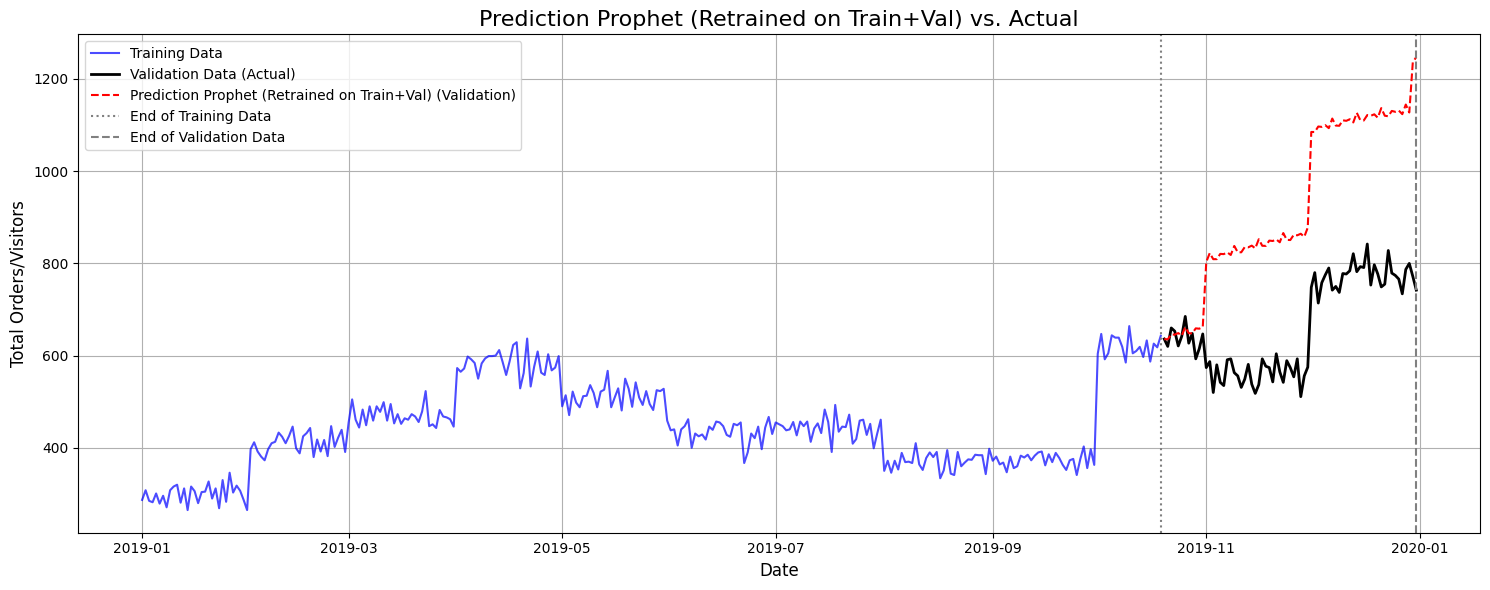

In [ ]:
# Plot
plot_predictions(
    y_trainval_visitors,
    y_test_visitors,
    None,
    y_pred_prophet_test_series_visitors,
    None,
    "Prophet (Retrained on Train+Val)"
)

**Insights:**
1. Although Prophet is the best model for validation data, it seems that the performance becomes poor when it's trying to predict unseen data
2. The Prophet model predicts a significant increase in the number of total orders/visitors in the future, while the actual data shows a slight increase as well as there is a large gap between actual and predicted value on testing data
3. Both predicted and actual data shows the seasonal pattern where the number of visitors increased in December




## **Number of Transactions**

In [ ]:
# merge training + validation for number of transactions
y_trainval_orders = pd.concat([y_train_orders, y_val_orders])
exog_trainval_orders = pd.concat([exog_train_orders, exog_val_orders])

#prepare dataset for Prophet
prophet_df_trainval_orders = y_trainval_orders.reset_index().rename(columns={'Order Date': 'ds', 'Total Orders': 'y'})
prophet_trainval_with_exog_orders = pd.merge(
    prophet_df_trainval_orders,
    exog_trainval_orders.reset_index().rename(columns={'Order Date':'ds'}),
    on='ds',
    how='left'
)


In [ ]:
m_final_orders = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.05
)

# Tambahkan semua kolom eksogen
for col in exog_cols:
    m_final_orders.add_regressor(col)

# Fit model
m_final_orders.fit(prophet_trainval_with_exog_orders)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_ipig8lg/g7_f09jt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_ipig8lg/bh471khi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84891', 'data', 'file=/tmp/tmp_ipig8lg/g7_f09jt.json', 'init=/tmp/tmp_ipig8lg/bh471khi.json', 'output', 'file=/tmp/tmp_ipig8lg/prophet_modelkcv5cf3k/prophet_model-20250730060355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:03:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:03:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# make future dataframe
future_test_orders = m_final_orders.make_future_dataframe(
    periods=len(y_test_orders),
    freq='D',
    include_history=False
)

# merge with exogen_test
future_test_orders = pd.merge(
    future_test_orders,
    exog_test_orders.reset_index().rename(columns={'Order Date': 'ds'}),
    on='ds',
    how='left'
)

# Prediction
forecast_test_orders = m_final_orders.predict(future_test_orders)
y_pred_prophet_test_orders = forecast_test_orders['yhat'].values
y_pred_prophet_test_orders = np.maximum(0, y_pred_prophet_test_orders)  # No negative predictions


y_pred_prophet_test_series_orders = pd.Series(
    y_pred_prophet_test_orders,
    index=y_test_orders.index
)

# Evaluation
rmse_prophet_test_orders, mae_prophet_test_orders, mape_prophet_test_orders = evaluate_model(
    y_test_orders,
    y_pred_prophet_test_orders,
    "Prophet (Test)"
)


--- Prophet (Test) ---
RMSE: 161.1418
MAE: 146.3017
MAPE: 22.18%


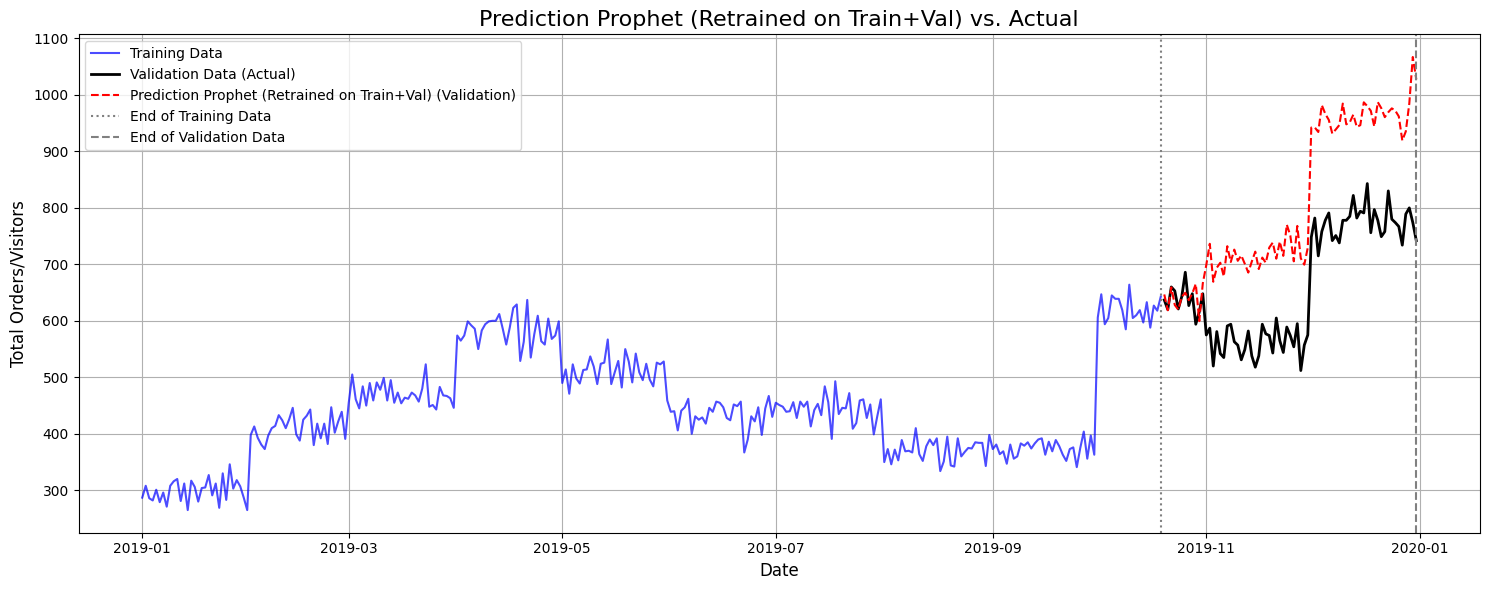

In [ ]:
# Plot
plot_predictions(
    y_trainval_orders,
    y_test_orders,
    None,
    y_pred_prophet_test_series_orders,
    None,
    "Prophet (Retrained on Train+Val)"
)

**Insights :**
1. Although Prophet becomes poor in predicting unseen data of the number of transactions, its perfomance is better than that in the number of visitors. It was shown by the MAPE where MAPE for predicting the number of transactions was 22.18%, while the MAPE for predicting the number of visitors was 40.18%
2. The Prophet model predicts a significant increase in the number of total orders/visitors in the future, while the actual data shows a slight increase as well as there is a large gap between actual and predicted value on testing data

**BUSINESS RECOMMENDATIONS**
1. Ensure the product availability throughout the end of year
2. Schedule staffing, customer support, delivery during peak days
3. Monitor actual vs predicted value, then improve the time series model
4. Launch end-year flash sales